In [1]:
import os
import random
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
import matplotlib.pyplot as plt

# modules
from dataloader import Cifar10DataLoader, MnistDataLoader
from dnn import DNN
from unet import CUNet
from diffusion import DiffusionUnet

2023-02-01 10:25:42.344554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:25:42.488387: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataloader_args = edict({"batch_size": 128, "epochs": 50, "da": False})
# dataloader = MnistDataLoader(dataloader_args=dataloader_args)
dataloader = Cifar10DataLoader(dataloader_args=dataloader_args)
train_dataset, valid_dataset, test_dataset = dataloader.load_dataset()

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Image', 'Test Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def plot_train(display_list):
  # plt.figure(figsize=(10, 10))
  label = ['Train', 'Test']
  for i in range(len(display_list)):
    plt.plot(display_list[i], label=label[i])
  plt.legend()
  plt.show()
  

2023-02-01 10:25:46.503754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:25:47.449915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14042 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:17:00.0, compute capability: 8.6


In [3]:
model_args = edict({"units":[128,64,32,10], "activations":["relu","relu","relu","softmax"]})
model = DNN(units=model_args.units, activations=model_args.activations)

In [4]:
train_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mt_loss_fn = tf.keras.metrics.Mean()
test_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mte_loss_fn = tf.keras.metrics.Mean()
opt_loss_fn = tf.keras.losses.categorical_crossentropy

train_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(0.1)

In [5]:
# @tf.function(experimental_relax_shapes=True, experimental_compile=None)
def _train_step(inputs, labels, first_batch=False):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = train_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(train_metrics(labels, predictions))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    mt_loss_fn.update_state(loss)
    
    return loss, metrics

def _test_step(inputs, labels):
    predictions = model(inputs)
    loss = test_loss_fn(labels, predictions)
    opt_loss = opt_loss_fn(labels, predictions)
    metrics = tf.reduce_mean(test_metrics(labels, predictions))
    mte_loss_fn.update_state(loss)
    
    return loss, metrics, opt_loss

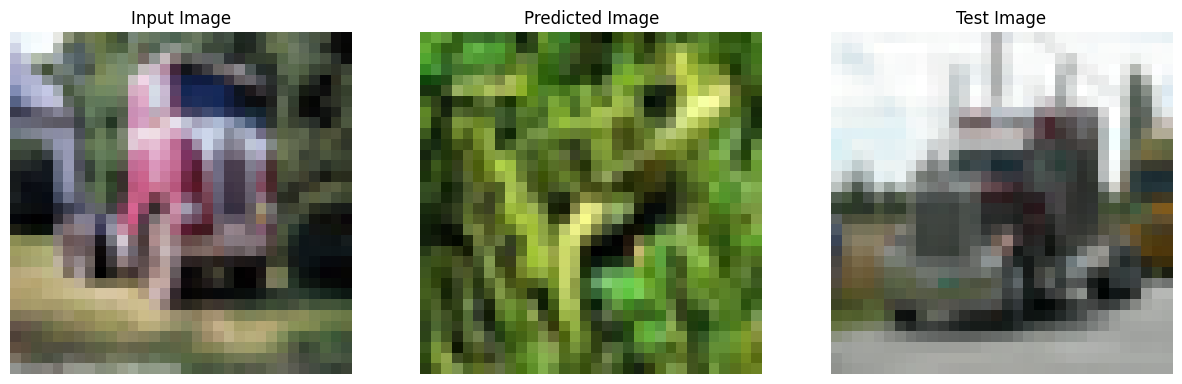

In [6]:
iter_train = iter(train_dataset)
iter_valid = iter(valid_dataset)
iter_test = iter(test_dataset)
test_data =  iter_test.get_next()

display([test_data["inputs"][0],test_data["inputs"][1],test_data["inputs"][2]])

In [7]:
model_opt = []
opt_label = []
def collect_model_operator(variables, loss):
    weights = [w.numpy() for w in variables]
    opt = DNN(units=model_args.units, 
            activations=model_args.activations,
            init_value=weights)
    opt_label.append(loss)
    model_opt.append(opt)

records = edict({'epoch':[],'train_loss':[],'test_loss':[],'train_metric':[],'test_metric':[]})
def obtain_model_opts(sample_start=30, sample_gap=20):
    for e in range(dataloader.info.epochs):
        mt_loss_fn.reset_states()
        train_metrics.reset_states()
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(dataloader.info.train_step):
            data = iter_train.get_next()
            train_loss, acc = _train_step(inputs=data["inputs"], labels=data["labels"])
            if (e*dataloader.info.train_step + step)%sample_gap ==0:
                if e >= sample_start:
                    test_loss, test_acc, opt_loss = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
                    collect_model_operator(model.trainable_variables, opt_loss)
                    
        test_loss, test_acc, _ = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
        records.epoch        += [e]
        records.train_loss   += [mt_loss_fn.result().numpy()]
        records.train_metric += [train_metrics.result().numpy()]
        records.test_loss    += [mte_loss_fn.result().numpy()]
        records.test_metric  += [test_metrics.result().numpy()]
        log = ""
        for k,v in records.items():
            log += "{}: {} ".format(k,v[-1])
        print(log)

In [8]:

def init_model_opt(raw_model_opt, data):
    
    def opt_test_step(opt, inputs, labels):
        predictions = opt(inputs)
        loss = test_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(test_metrics(labels, predictions))
        mte_loss_fn.update_state(loss)
        return loss, metrics

    for idx in range(len(raw_model_opt)):
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(1):
            data = test_data
            test_loss, test_acc = opt_test_step(opt=raw_model_opt[idx], inputs=data["inputs"], labels=data["labels"])
        print("Init: opt_id:{}, Test loss:{}, Test acc:{}".format(idx,
                                                        mte_loss_fn.result().numpy(),
                                                        test_metrics.result().numpy()))
            
def hard_save_model_opt(online_model_opt, path="./model_opt"):
    init_model_opt(online_model_opt, test_data)
    for idx in range(len(online_model_opt)):
        mpath = os.path.join(path, "opt_{}".format(idx))
        online_model_opt[idx].save(mpath, overwrite=True, save_format='tf')

def load_model_opt(path="./model_opt"):
    offline_model_opt = []
    model_opt_list = os.listdir(path=path)
    for idx in range(len(model_opt_list)):
        mpath = os.path.join(path,  "opt_{}".format(idx))
        offline_model_opt.append(tf.keras.models.load_model(mpath))
    init_model_opt(offline_model_opt, test_data)
    return offline_model_opt

In [9]:
# training
obtain_model_opts(sample_start=30, sample_gap=20) 
print(len(model_opt))

2023-02-01 10:25:52.358273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 10:25:52.510954: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x46145790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-01 10:25:52.510994: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-02-01 10:25:52.614339: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch: 0 train_loss: 2.0578010082244873 test_loss: 1.9173297882080078 train_metric: 0.23719951510429382 test_metric: 0.2734375 
epoch: 1 train_loss: 1.84075927734375 test_loss: 1.7797300815582275 train_metric: 0.3348572254180908 test_metric: 0.328125 
epoch: 2 train_loss: 1.7451050281524658 test_loss: 1.771651029586792 train_metric: 0.37391722202301025 test_metric: 0.4296875 
epoch: 3 train_loss: 1.680178165435791 test_loss: 1.6530776023864746 train_metric: 0.39569297432899475 test_metric: 0.453125 
epoch: 4 train_loss: 1.6272698640823364 test_loss: 1.508758783340454 train_metric: 0.41614532470703125 test_metric: 0.5 
epoch: 5 train_loss: 1.5857412815093994 test_loss: 1.5887322425842285 train_metric: 0.4323267638683319 test_metric: 0.4375 
epoch: 6 train_loss: 1.5478765964508057 test_loss: 1.4133108854293823 train_metric: 0.44527992606163025 test_metric: 0.4765625 
epoch: 7 train_loss: 1.5155669450759888 test_loss: 1.4169862270355225 train_metric: 0.45751121640205383 test_metric: 0.546

In [11]:
GIAO_EPOCH = 1000
GIAO_BATCH = 1

giao_optimizer = tf.keras.optimizers.Adam(1e-4)
giao_loss_fn = tf.keras.losses.MeanSquaredError()
def _opt_train_step(unet, regs, train_inputs, train_labels, labels):
    gradients = []
    losses = []
    for idx in range(len(regs)):
        with tf.GradientTape() as tape:
            pseudo_inputs = unet(train_inputs)
            # pseudo_inputs = train_inputs
            predictions = regs[idx](pseudo_inputs)
            reg_loss = opt_loss_fn(train_labels, predictions)
            # print(reg_loss, labels[idx])
            giao_loss = giao_loss_fn(labels[idx], reg_loss)
            # giao_loss = tf.math.reduce_sum(labels[idx]-reg_loss)
            losses.append(giao_loss)
            # print(giao_loss)
            grad = tape.gradient(giao_loss, unet.model.trainable_variables)
            if gradients == []:
                gradients = grad
            else:
                gradients = [sg1+sg2 for sg1,sg2 in zip(grad, gradients)]
        
    reduced_grads = [g/GIAO_BATCH for g in gradients]
    giao_optimizer.apply_gradients(zip(reduced_grads, unet.model.trainable_variables))
    reduced_loss = sum(losses)/GIAO_BATCH
    return reduced_loss, pseudo_inputs

In [12]:

train_data = iter_train.get_next()

# unet = UNet(input_shape=[32, 32, 3])
# unet = CUNet(input_shape=[32, 32, 3])
unet = DiffusionUnet()

2023-02-01 10:33:02.900604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-01 10:33:08.801082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Epoch:0 GIAO Train Loss:7.137200355529785


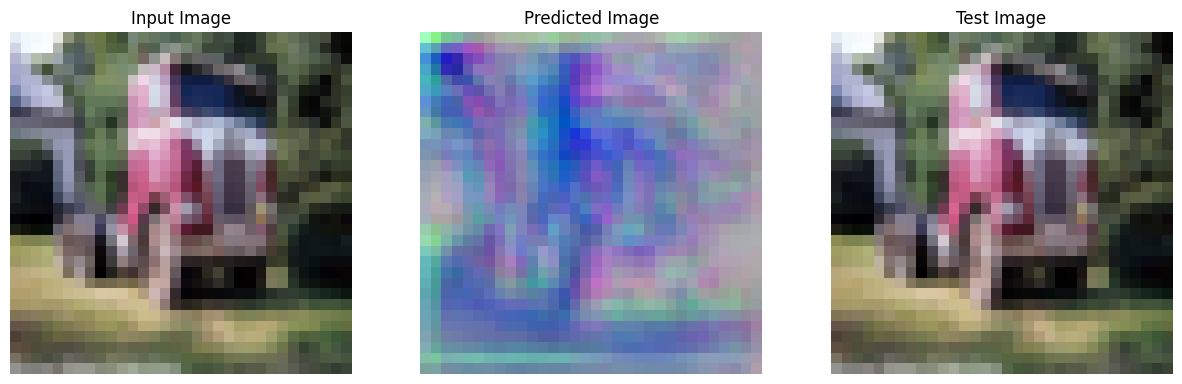

Epoch:25 GIAO Train Loss:3.5355799198150635


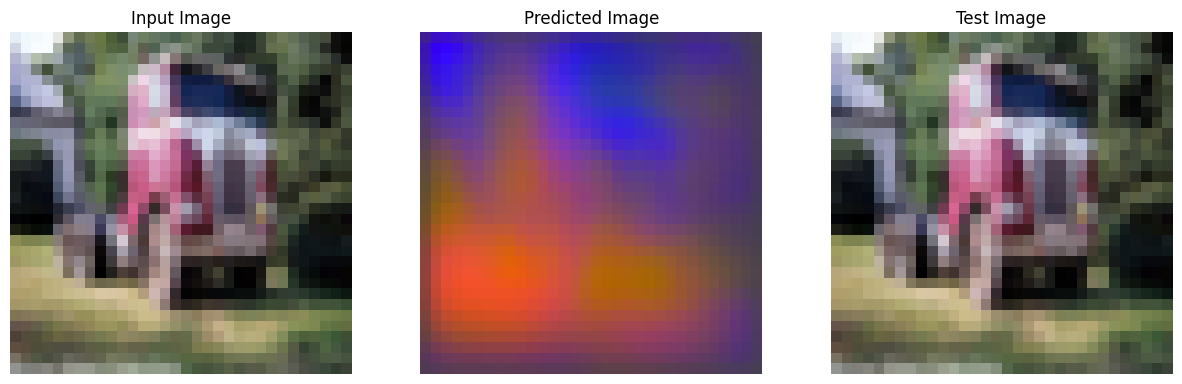

Epoch:50 GIAO Train Loss:1.0644299983978271


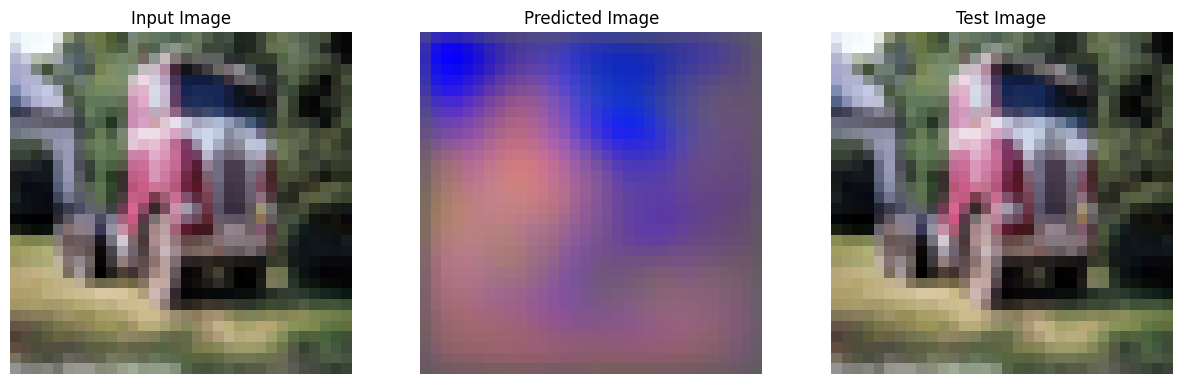

Epoch:75 GIAO Train Loss:0.5398223400115967


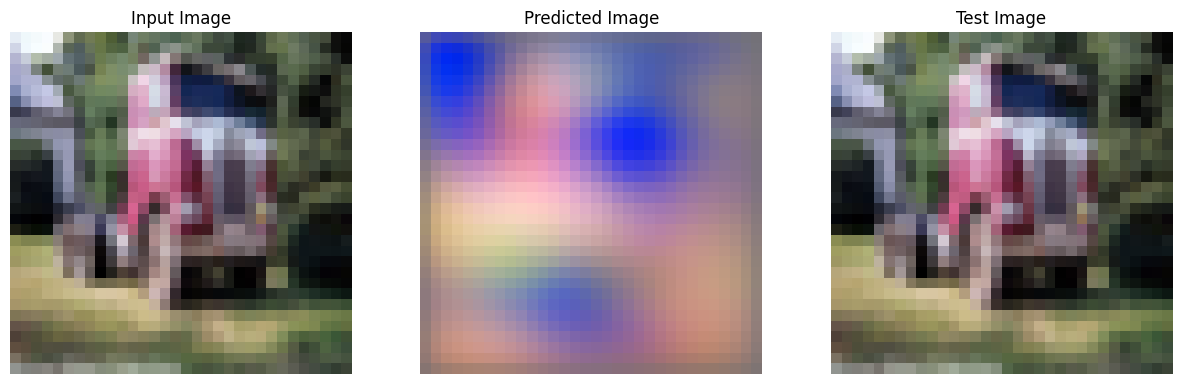

Epoch:100 GIAO Train Loss:0.5763899087905884


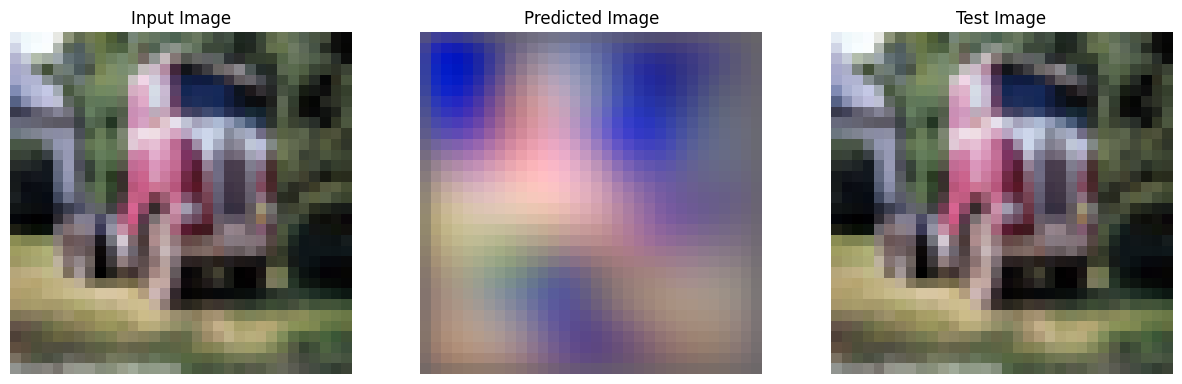

Epoch:125 GIAO Train Loss:0.5095569491386414


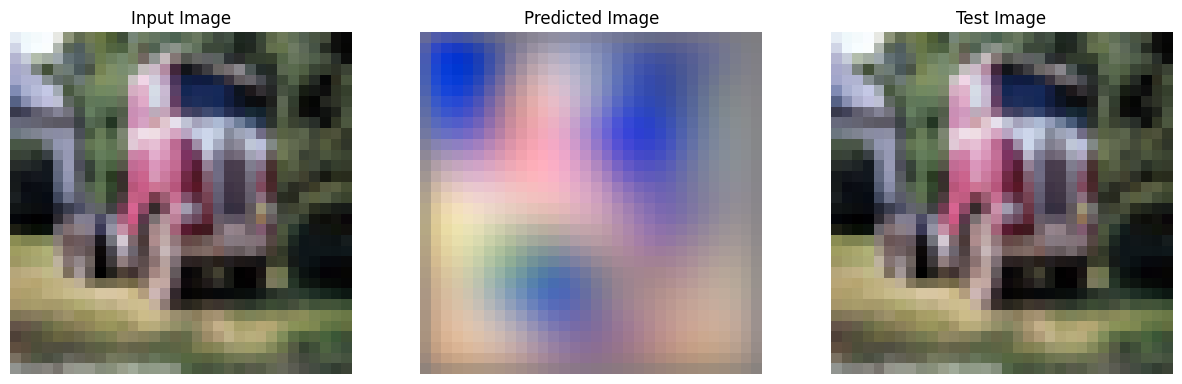

Epoch:150 GIAO Train Loss:0.401500403881073


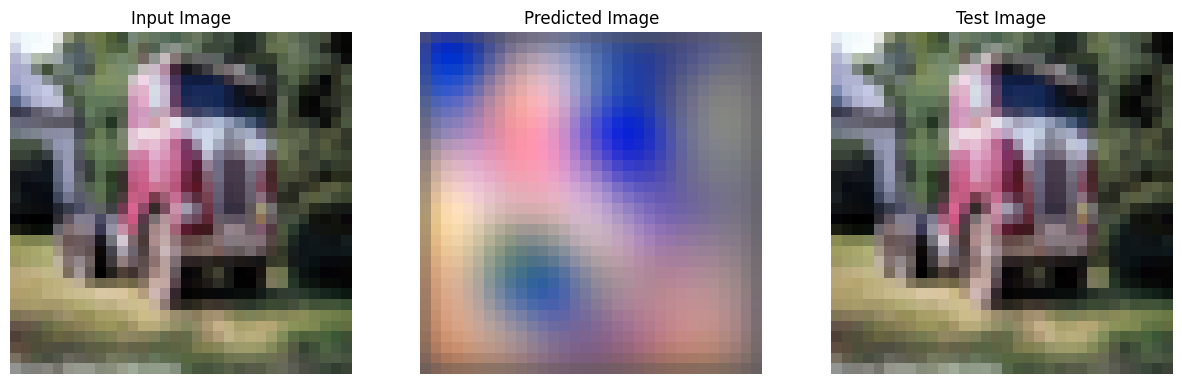

Epoch:175 GIAO Train Loss:0.21908904612064362


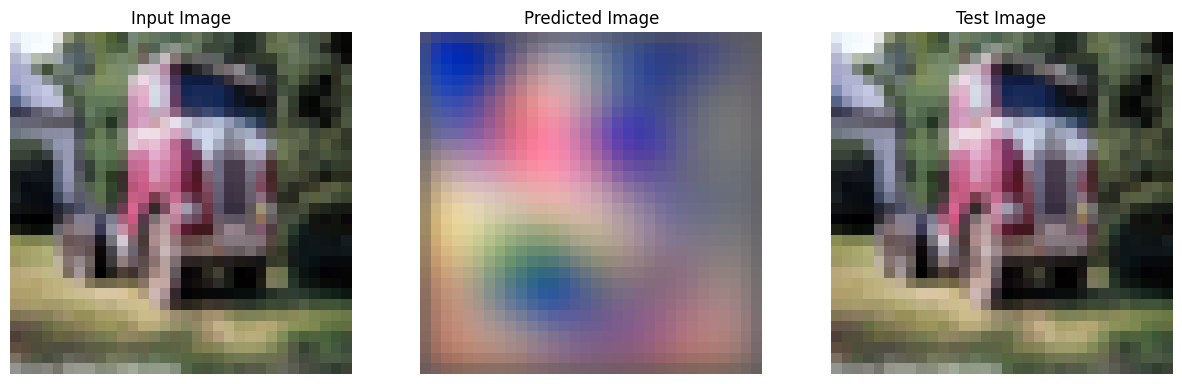

Epoch:200 GIAO Train Loss:0.3961215615272522


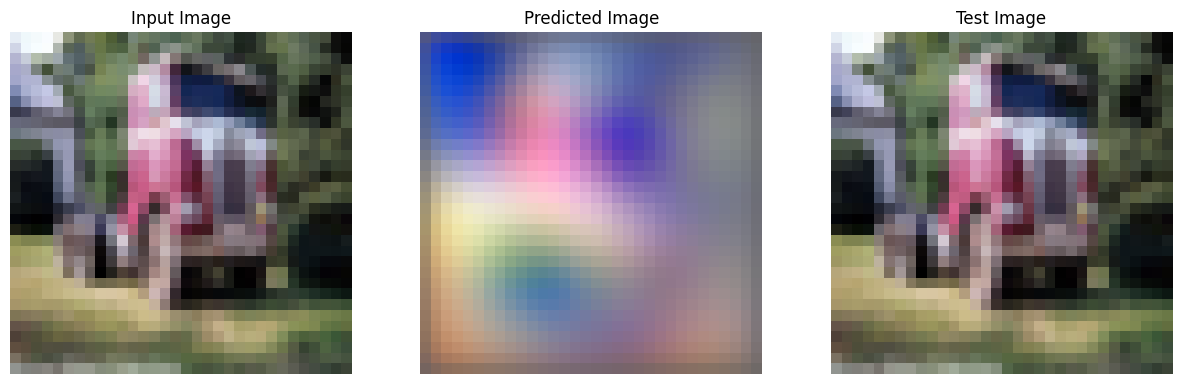

Epoch:225 GIAO Train Loss:0.4774046540260315


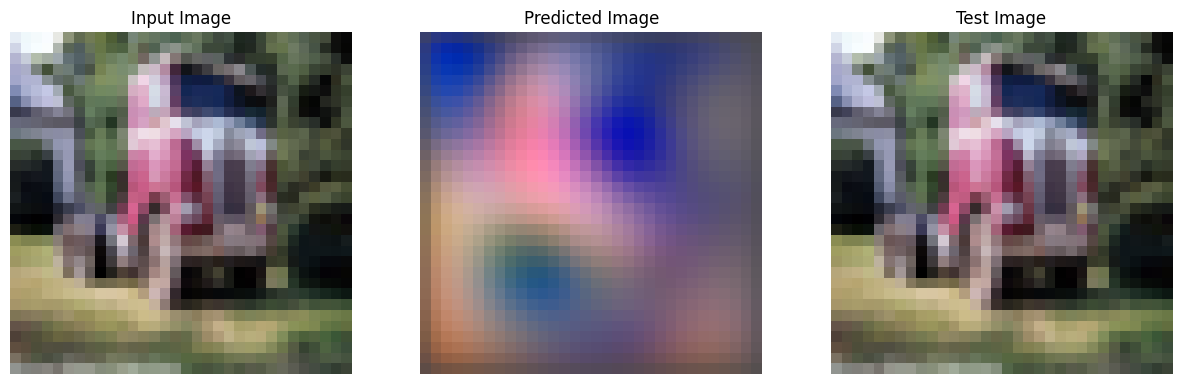

Epoch:250 GIAO Train Loss:0.3124532997608185


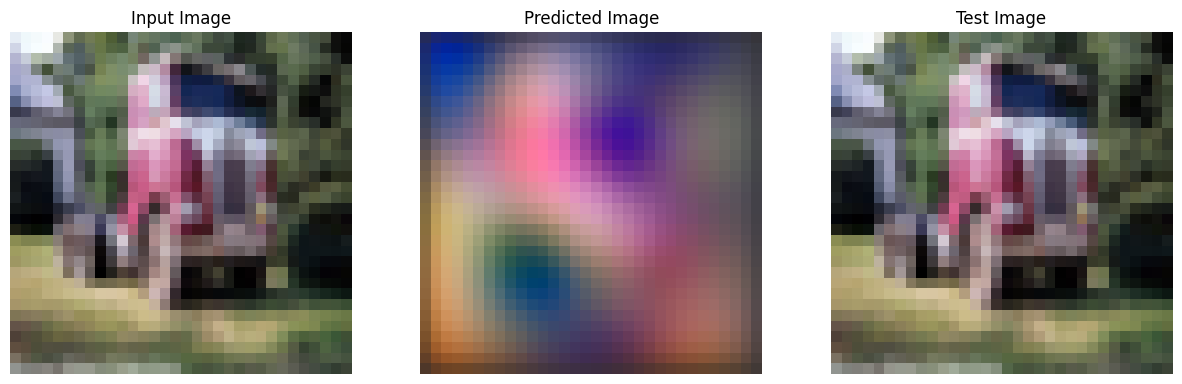

Epoch:275 GIAO Train Loss:0.4217483401298523


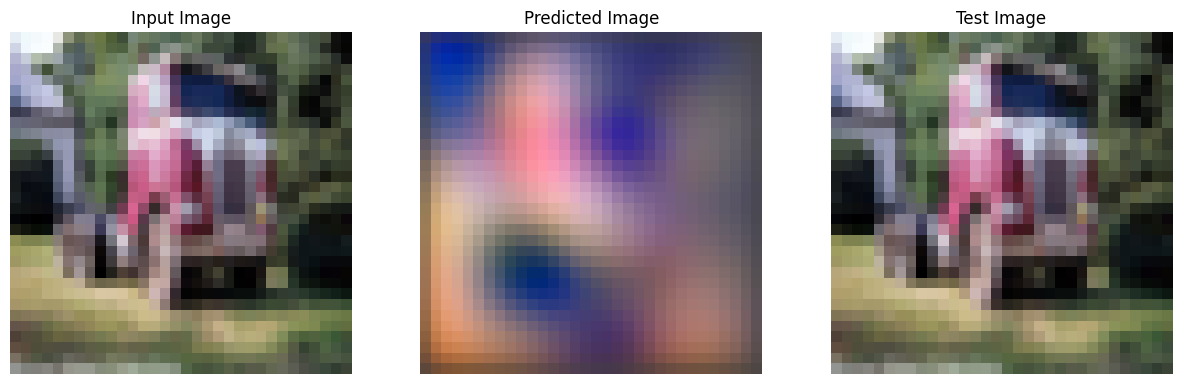

Epoch:300 GIAO Train Loss:0.22872990369796753


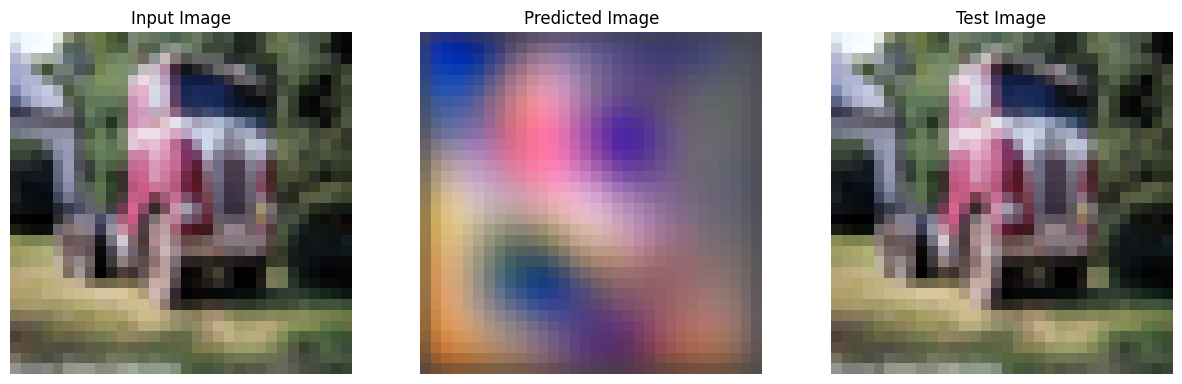

Epoch:325 GIAO Train Loss:0.294778436422348


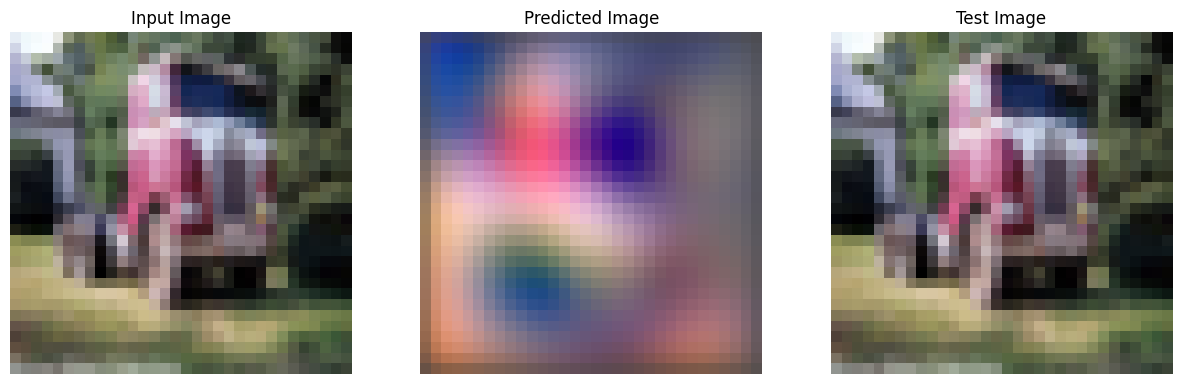

Epoch:350 GIAO Train Loss:0.30280667543411255


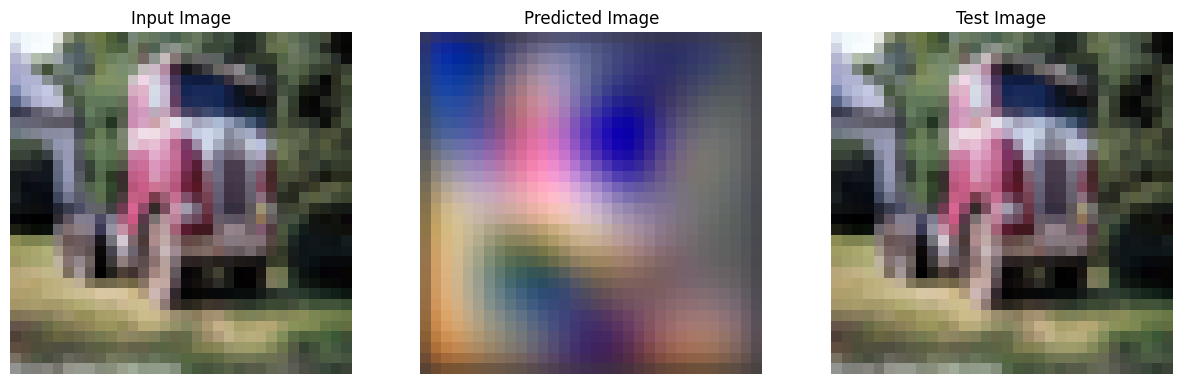

Epoch:375 GIAO Train Loss:0.3630664348602295


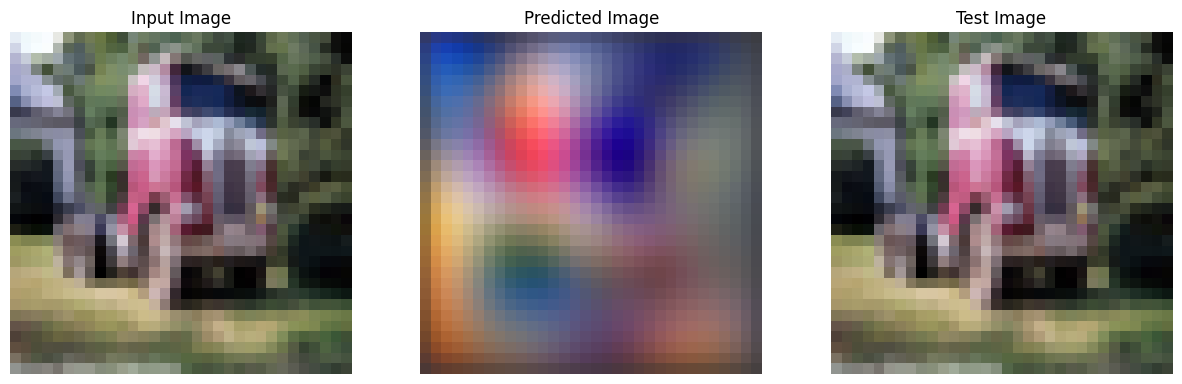

Epoch:400 GIAO Train Loss:0.3122944235801697


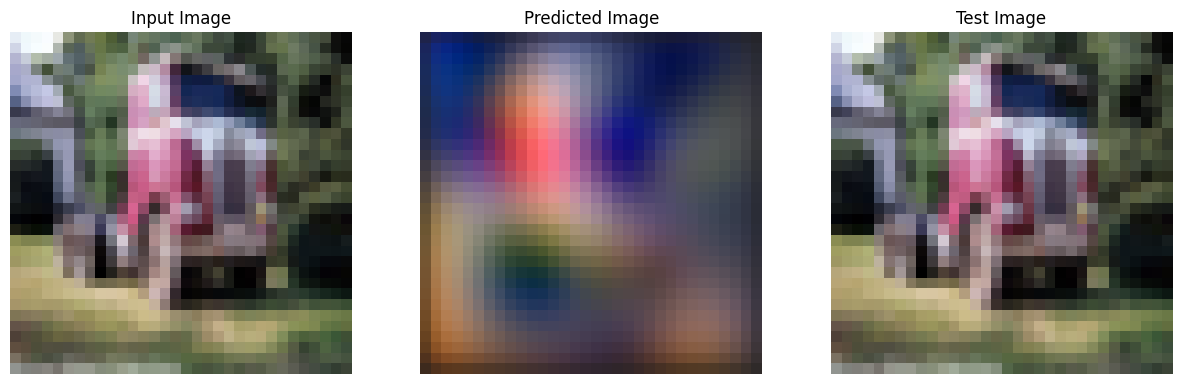

Epoch:425 GIAO Train Loss:0.4516255259513855


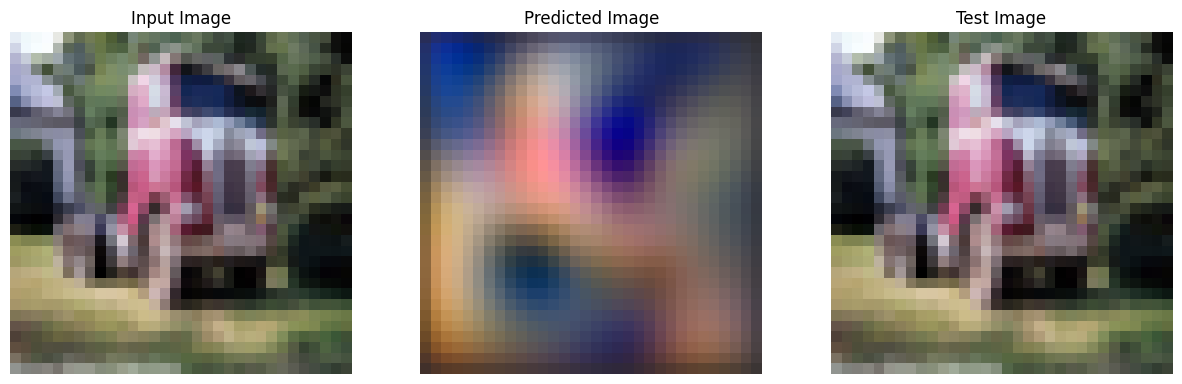

Epoch:450 GIAO Train Loss:0.2817149758338928


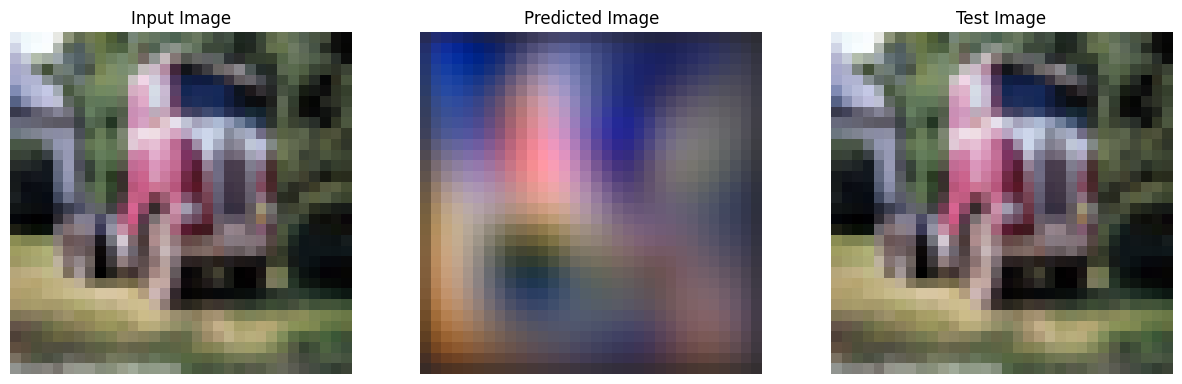

Epoch:475 GIAO Train Loss:0.3395131528377533


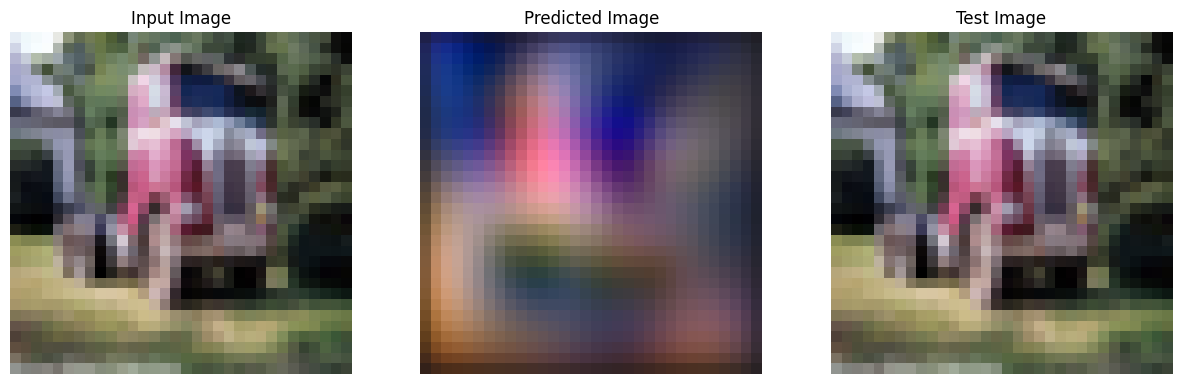

Epoch:500 GIAO Train Loss:0.17872031033039093


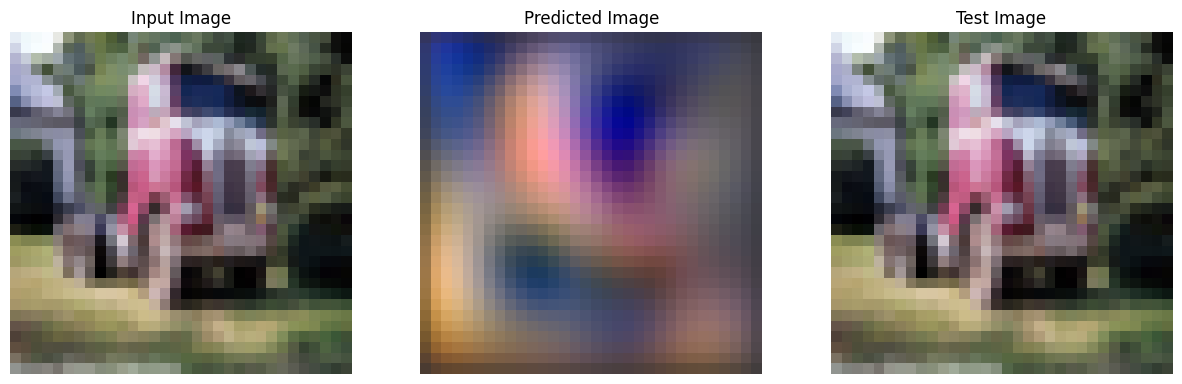

Epoch:525 GIAO Train Loss:0.40322163701057434


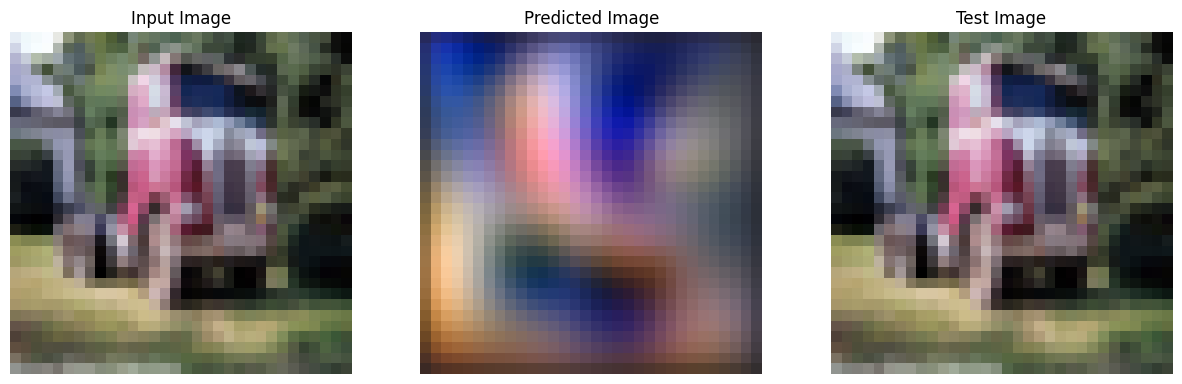

Epoch:550 GIAO Train Loss:0.23533901572227478


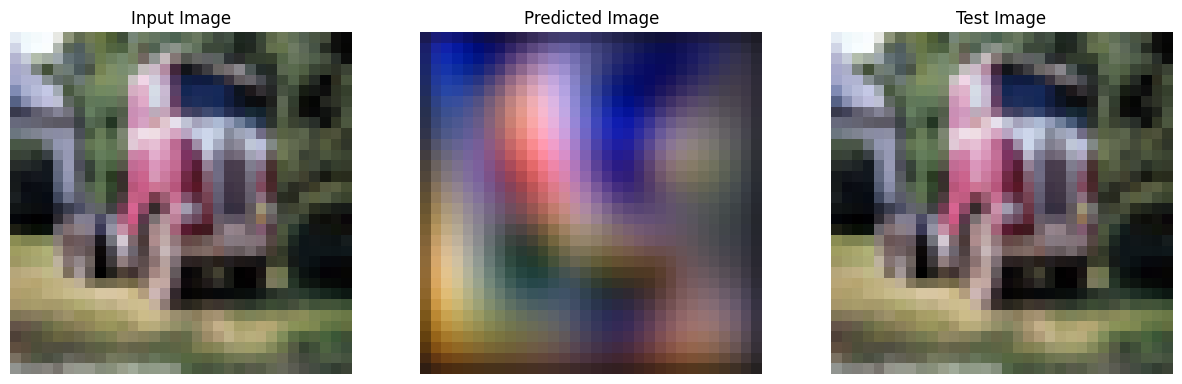

Epoch:575 GIAO Train Loss:0.289495050907135


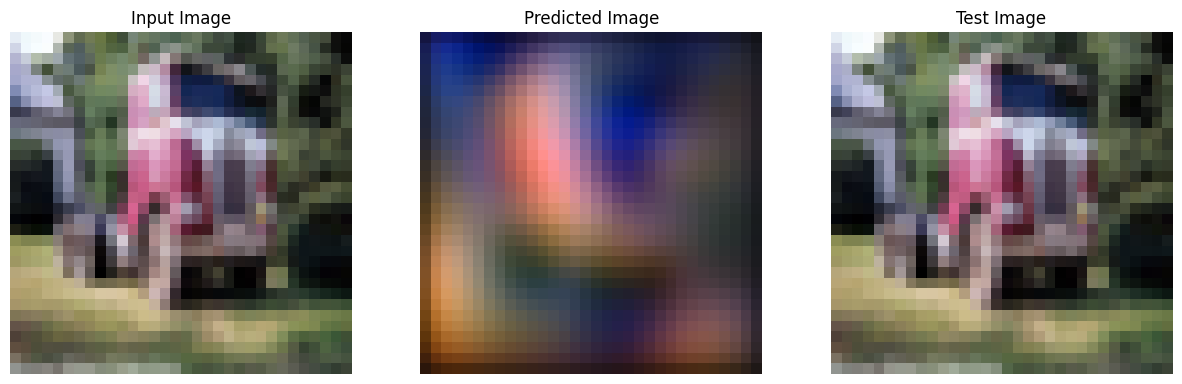

Epoch:600 GIAO Train Loss:0.3223816752433777


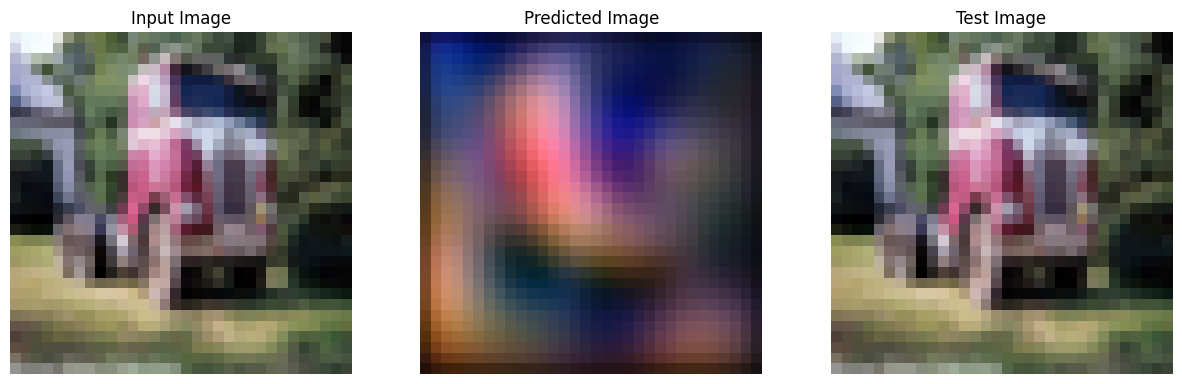

Epoch:625 GIAO Train Loss:0.25202733278274536


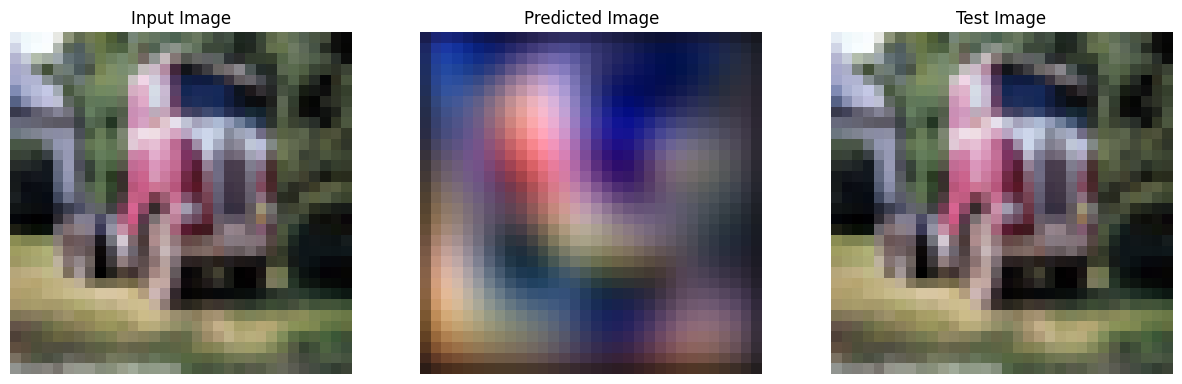

Epoch:650 GIAO Train Loss:0.3316934108734131


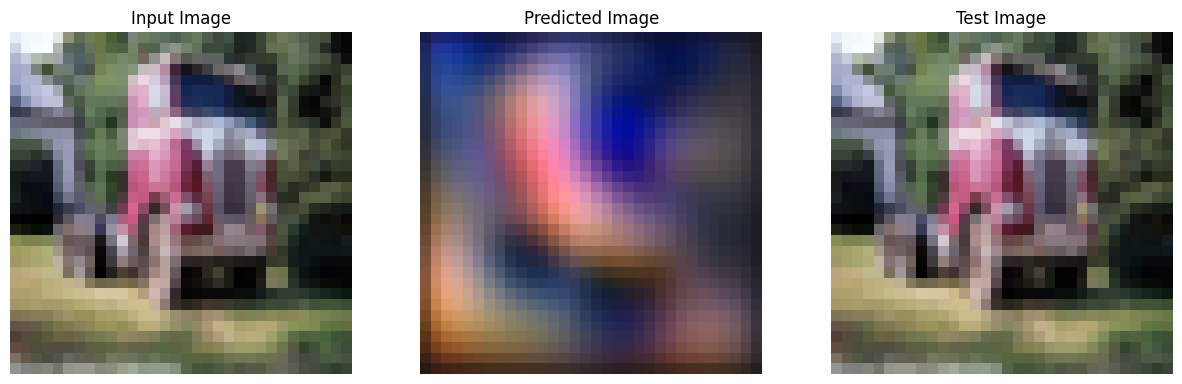

Epoch:675 GIAO Train Loss:0.22810977697372437


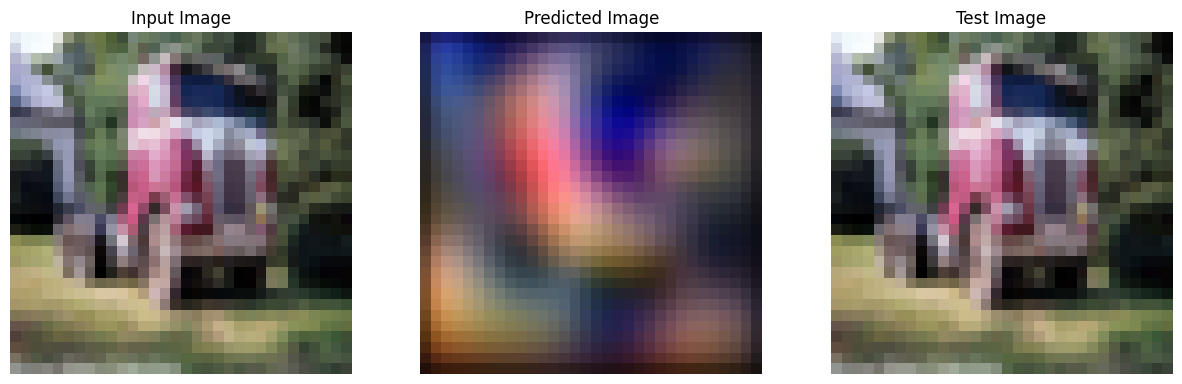

Epoch:700 GIAO Train Loss:0.34516406059265137


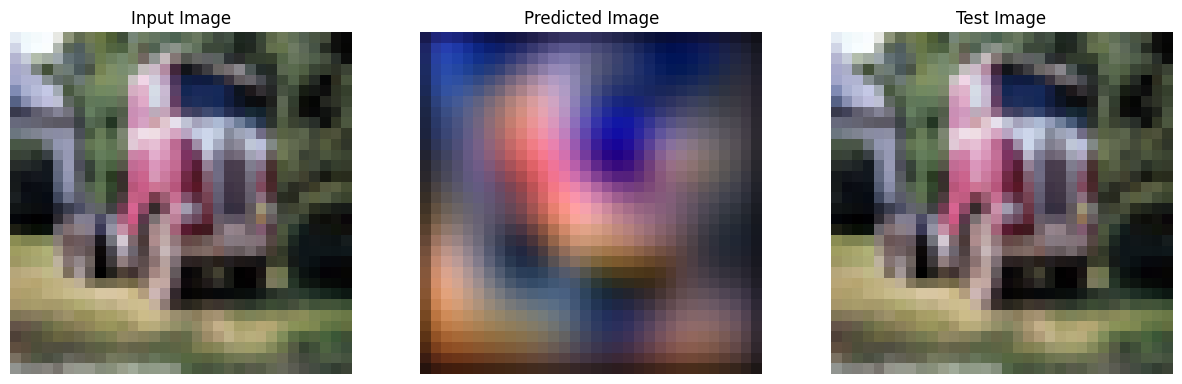

Epoch:725 GIAO Train Loss:0.25595948100090027


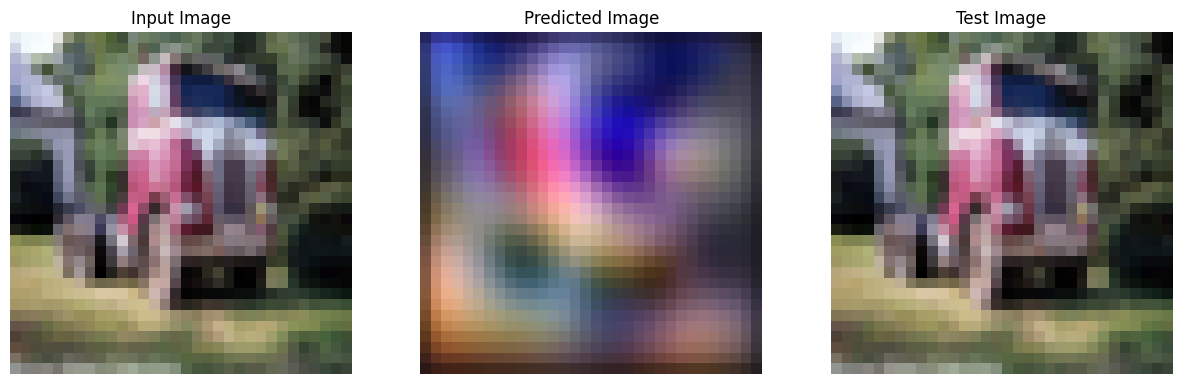

Epoch:750 GIAO Train Loss:0.3098943531513214


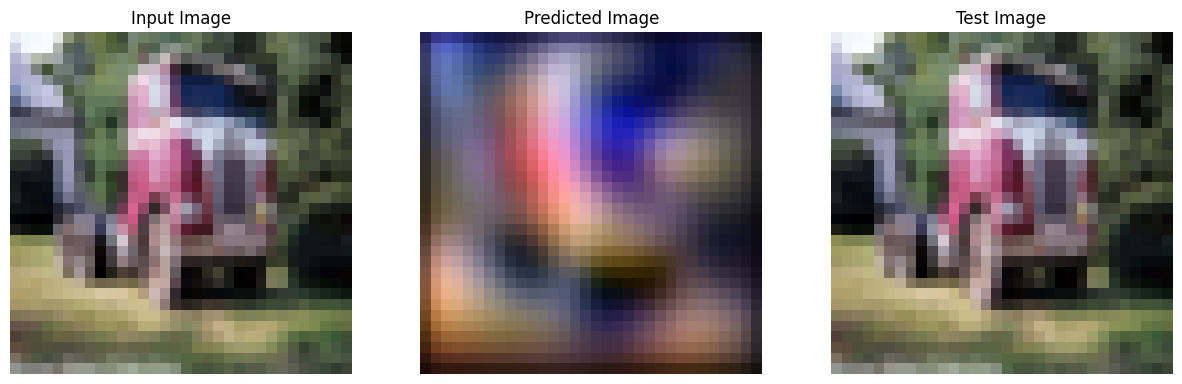

Epoch:775 GIAO Train Loss:0.28299766778945923


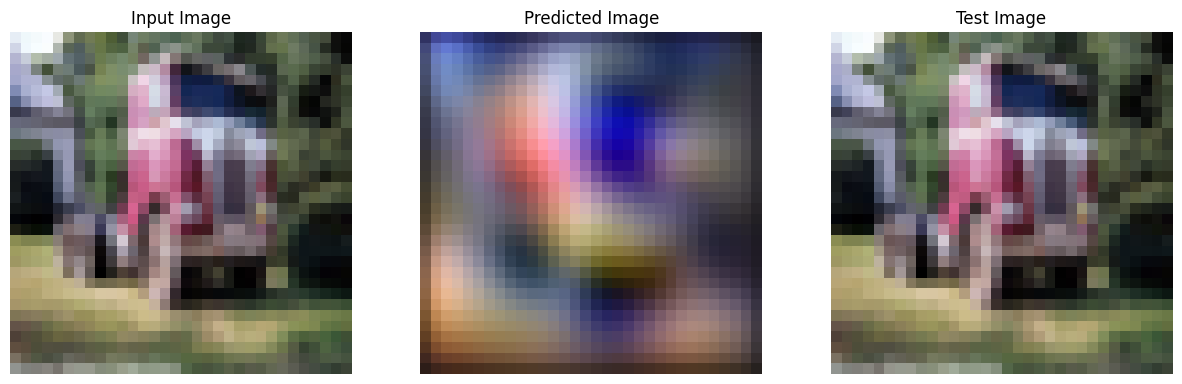

Epoch:800 GIAO Train Loss:0.30480387806892395


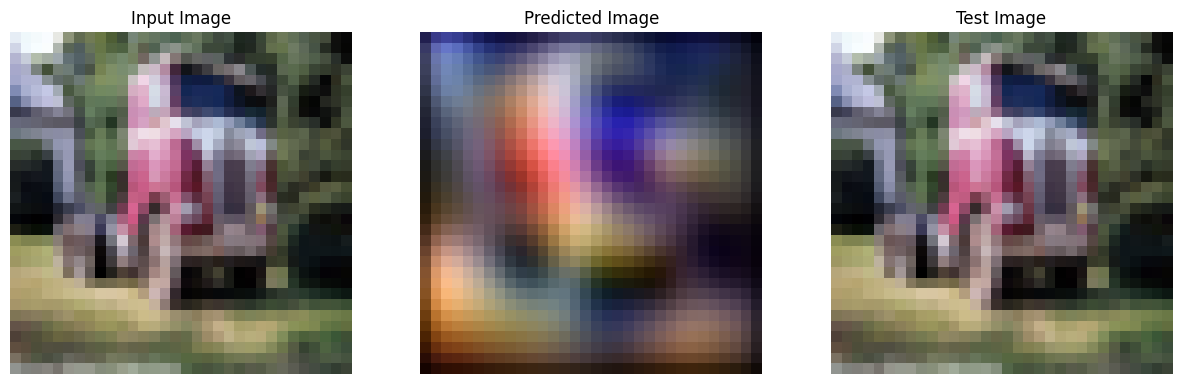

Epoch:825 GIAO Train Loss:0.35026830434799194


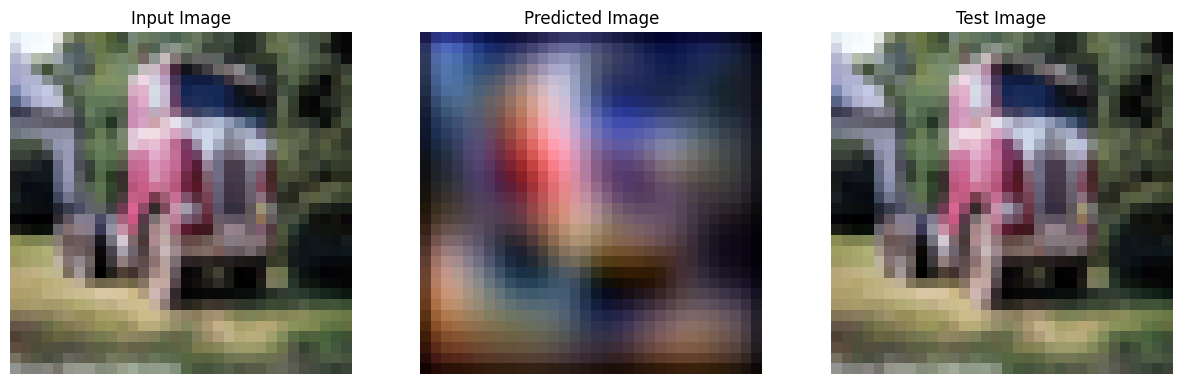

Epoch:850 GIAO Train Loss:0.4171299338340759


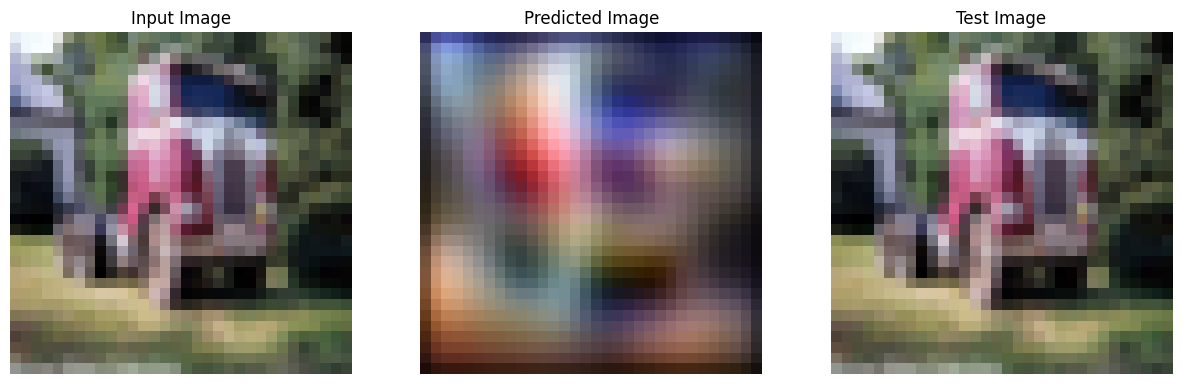

Epoch:875 GIAO Train Loss:0.19491851329803467


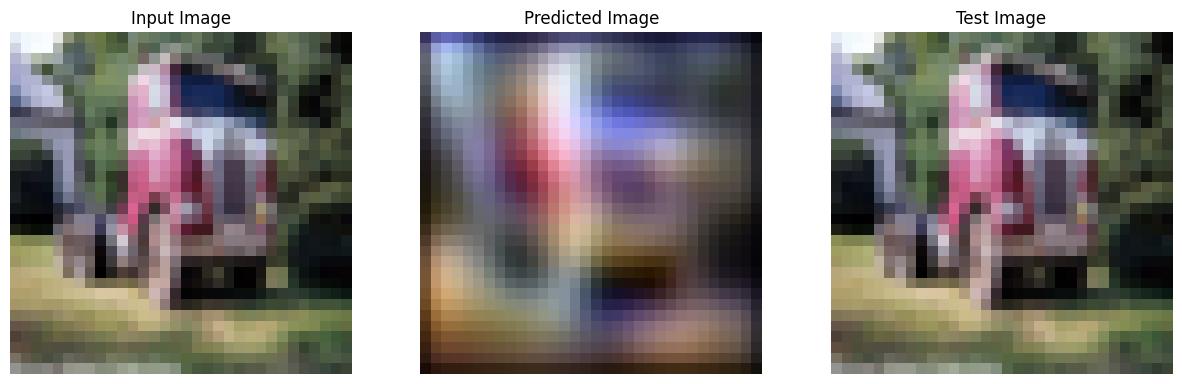

Epoch:900 GIAO Train Loss:0.17267316579818726


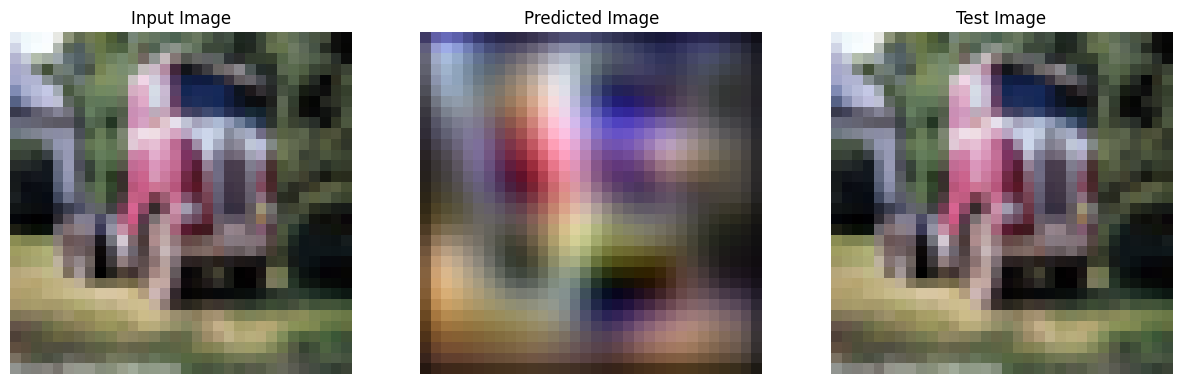

Epoch:925 GIAO Train Loss:0.17913661897182465


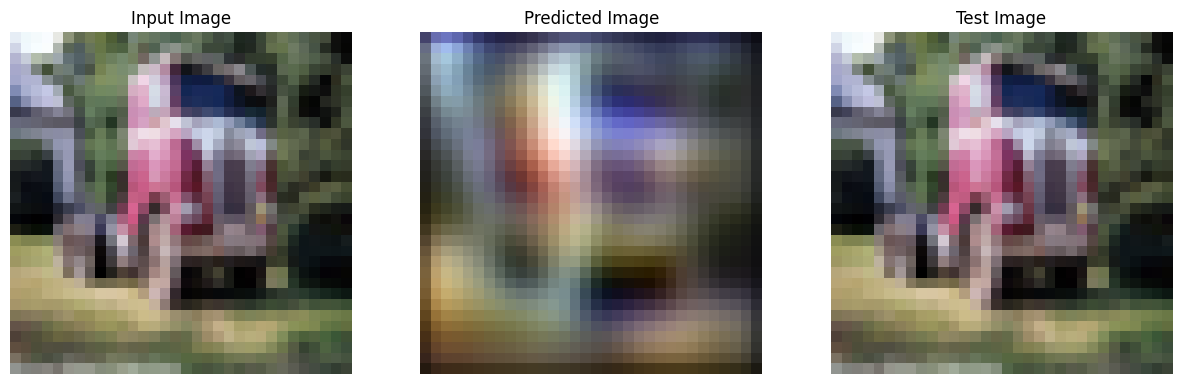

Epoch:950 GIAO Train Loss:0.2217503786087036


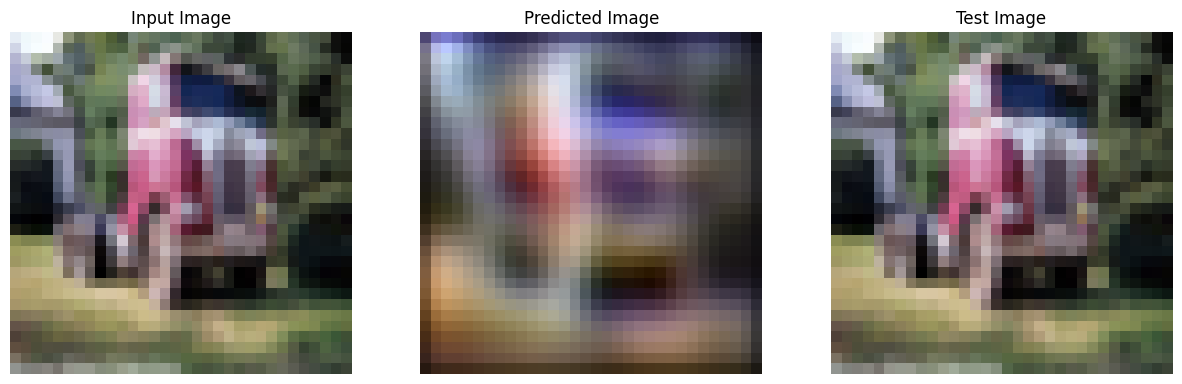

Epoch:975 GIAO Train Loss:0.11009493470191956


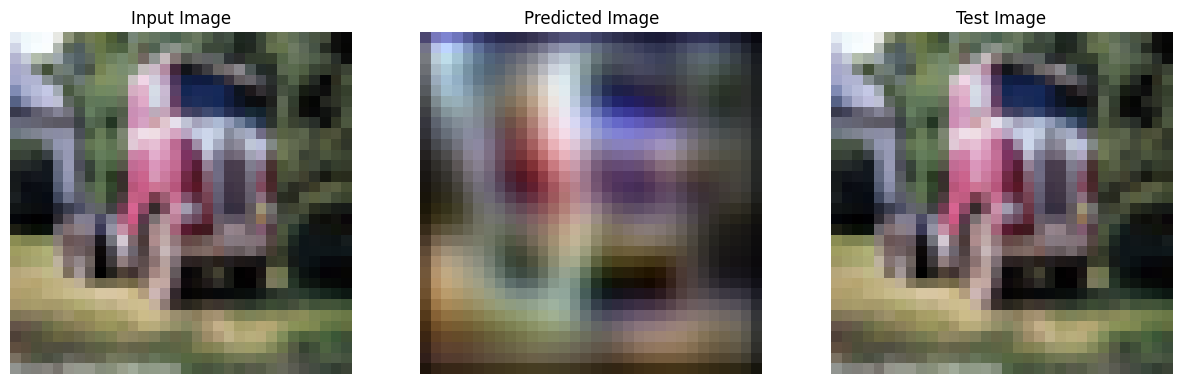

In [13]:
for i in range(GIAO_EPOCH):
    idx = random.sample(range(len(model_opt)), GIAO_BATCH)
    labels = [opt_label[i] for i in idx]
    regs = [model_opt[i] for i in idx]
    giao_train_loss, pseudo_inputs = _opt_train_step(unet, regs, test_data["inputs"], test_data["labels"], labels)
    if i % 25 == 0:
        print("Epoch:{} GIAO Train Loss:{}".format(i, giao_train_loss))
        display([test_data["inputs"].numpy()[0], pseudo_inputs.numpy()[0], test_data["inputs"][0]])
        

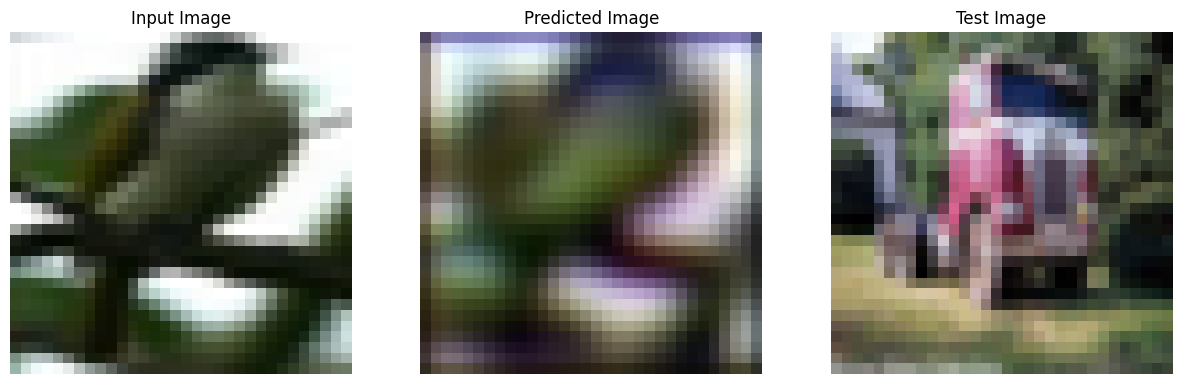

In [14]:
aug_train = unet(train_data["inputs"])
display([train_data["inputs"].numpy()[0], aug_train.numpy()[0], test_data["inputs"][0]])

Epoch:0 GIAO Train Loss:1.715330958366394


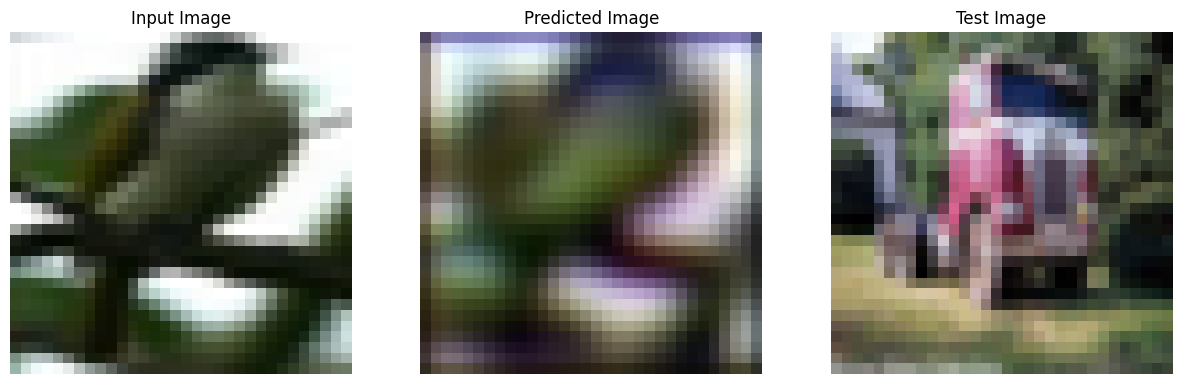

Epoch:25 GIAO Train Loss:0.7699960470199585


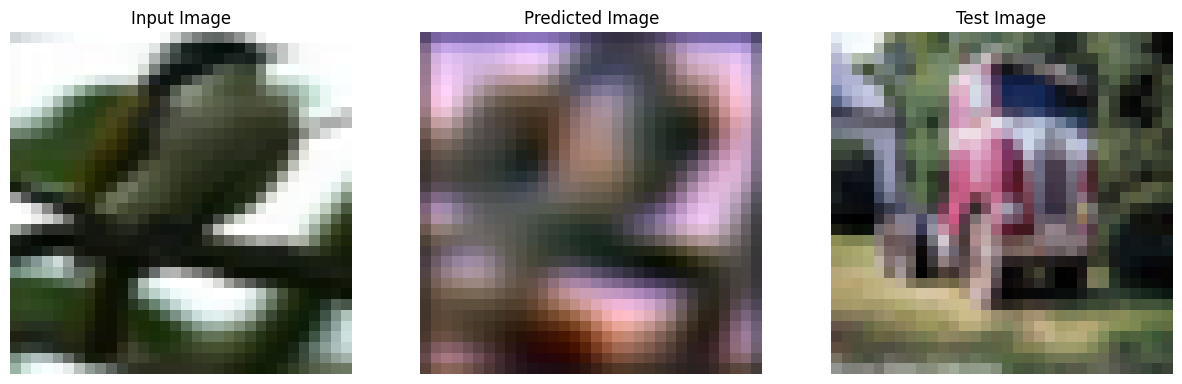

Epoch:50 GIAO Train Loss:0.8135457038879395


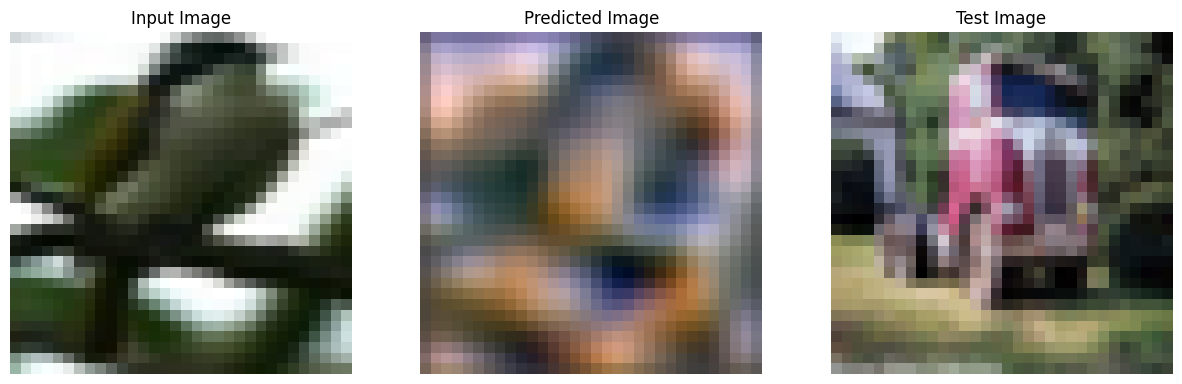

Epoch:75 GIAO Train Loss:0.743520975112915


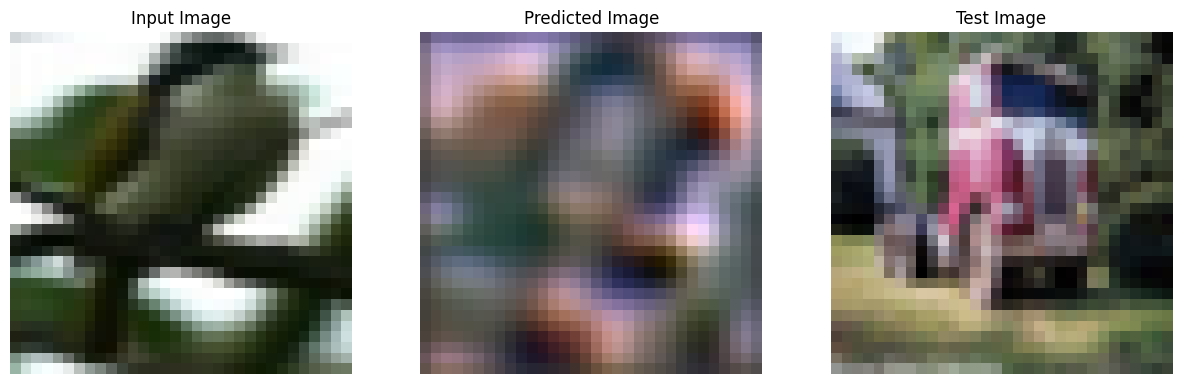

Epoch:100 GIAO Train Loss:0.44577762484550476


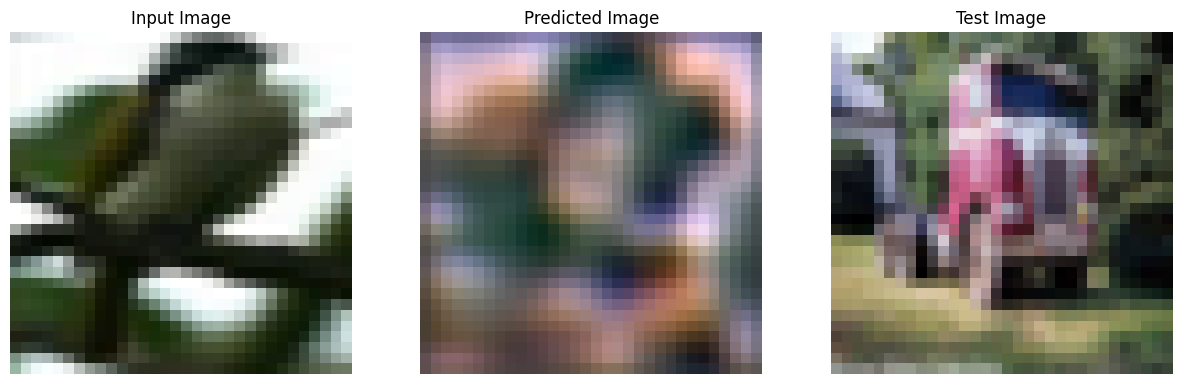

Epoch:125 GIAO Train Loss:0.7500536441802979


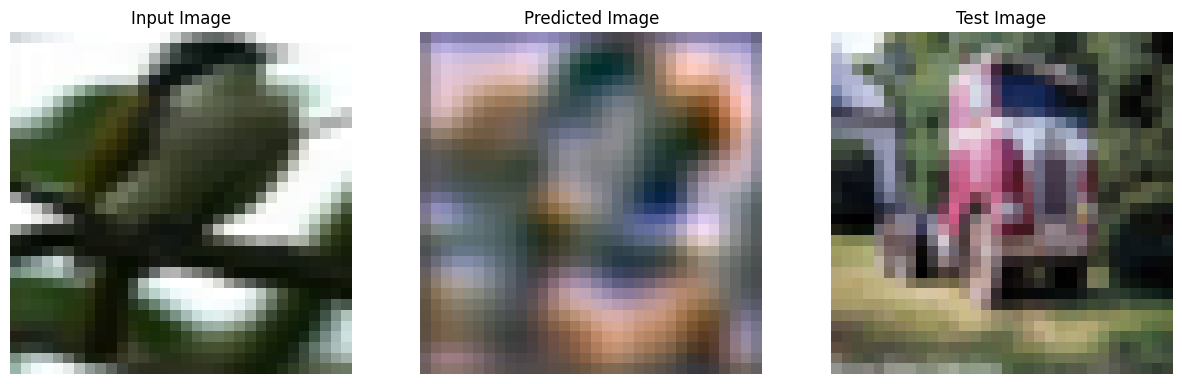

Epoch:150 GIAO Train Loss:0.449529767036438


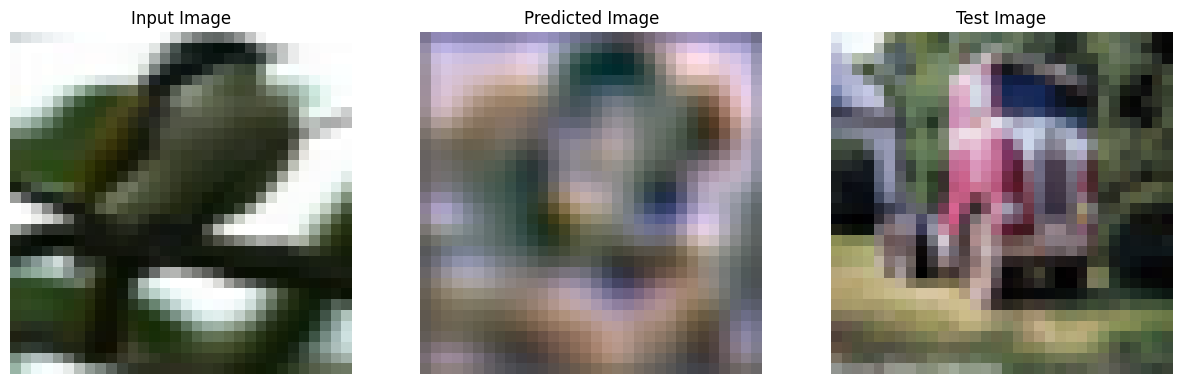

Epoch:175 GIAO Train Loss:0.4799424409866333


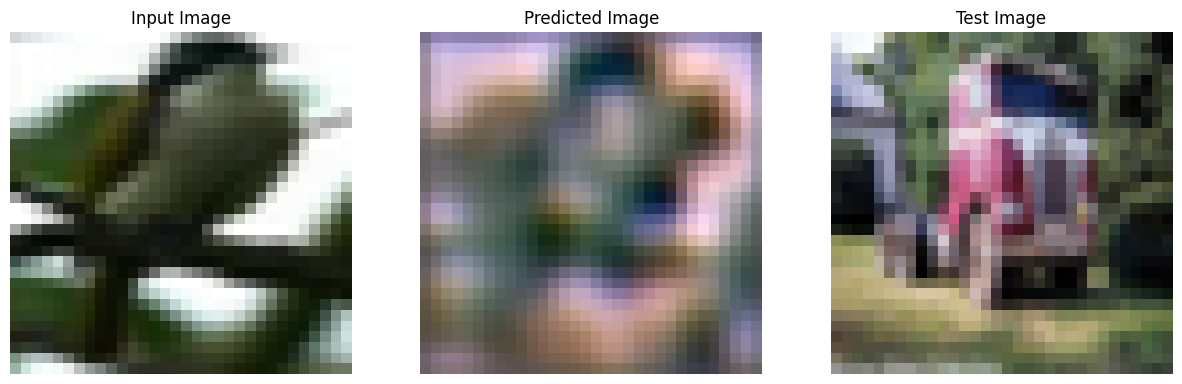

Epoch:200 GIAO Train Loss:0.32170677185058594


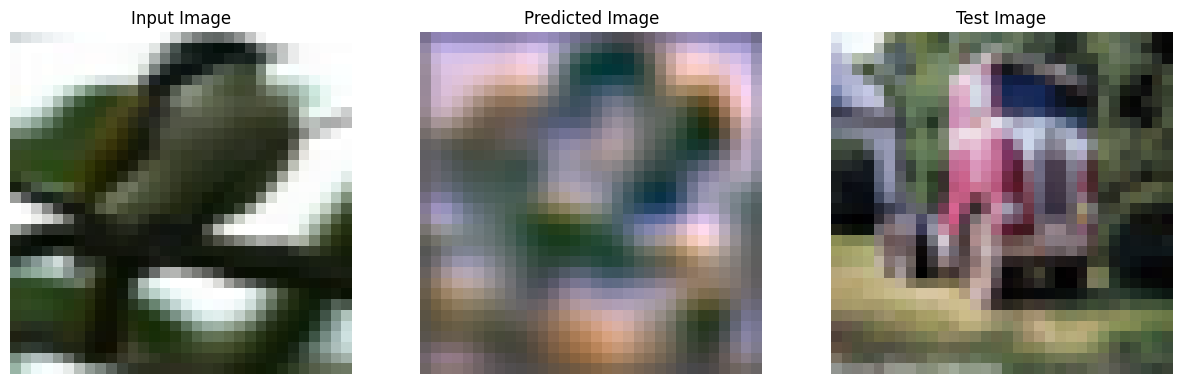

Epoch:225 GIAO Train Loss:0.4675077795982361


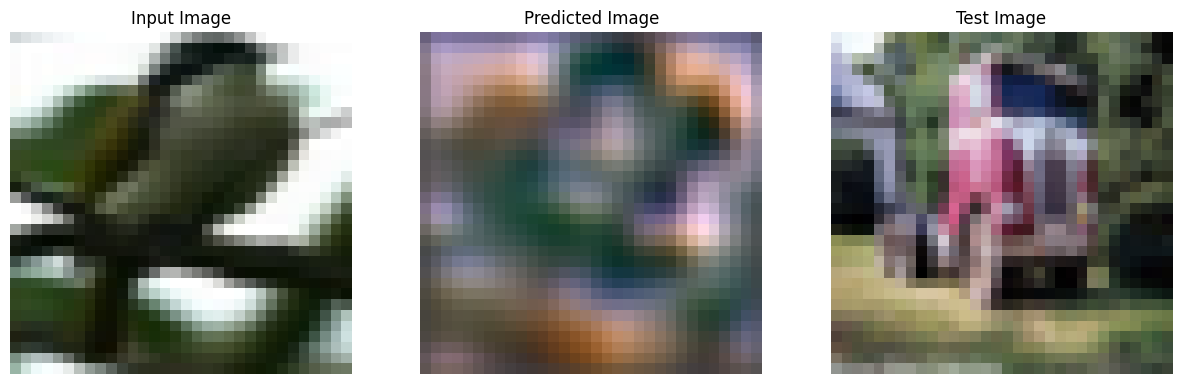

Epoch:250 GIAO Train Loss:0.45855051279067993


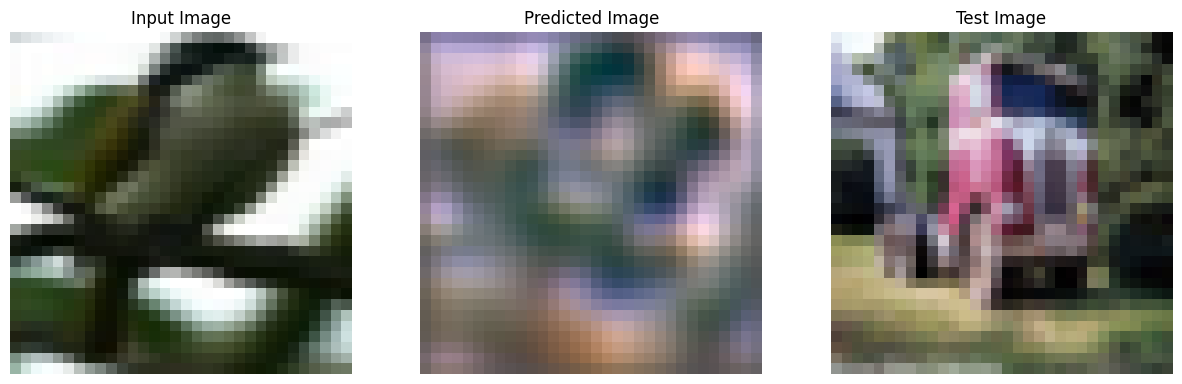

Epoch:275 GIAO Train Loss:0.2680898904800415


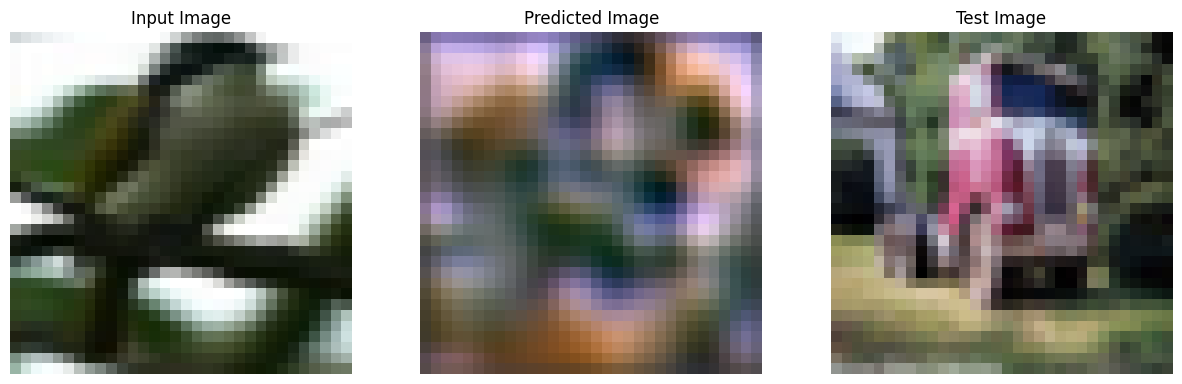

Epoch:300 GIAO Train Loss:0.36068958044052124


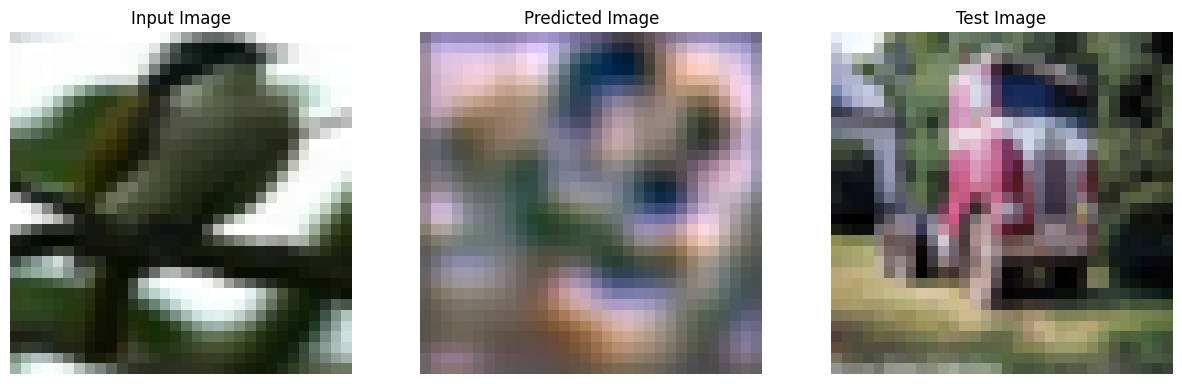

Epoch:325 GIAO Train Loss:0.4034409523010254


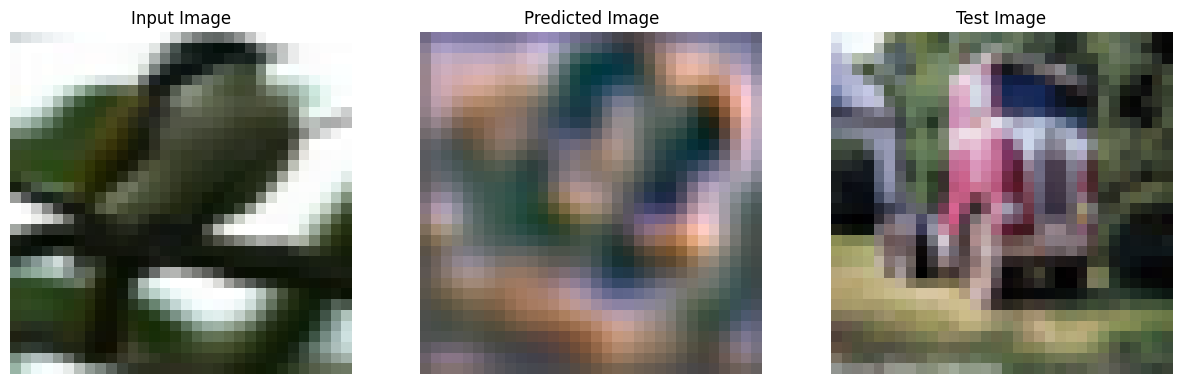

Epoch:350 GIAO Train Loss:0.38095882534980774


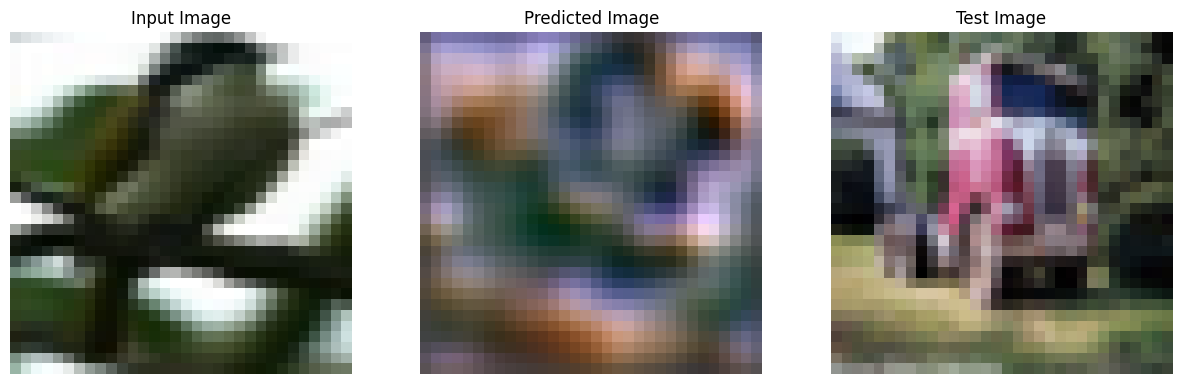

Epoch:375 GIAO Train Loss:0.43742668628692627


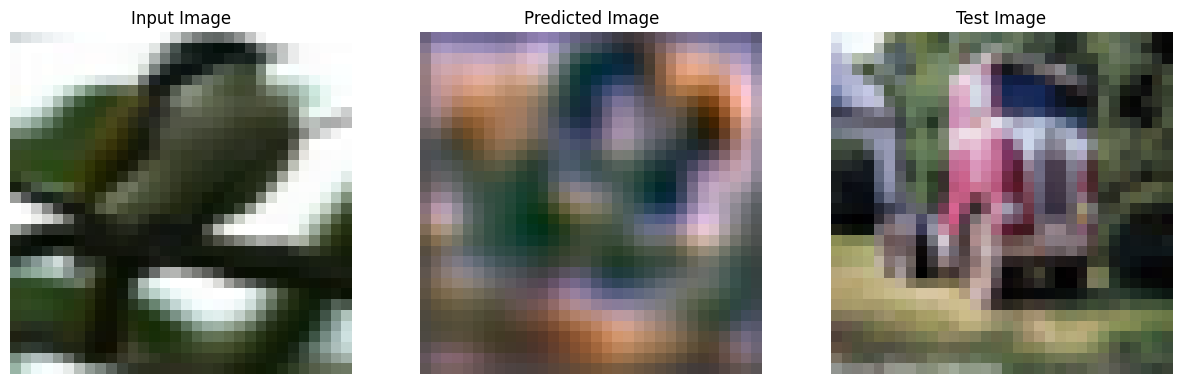

Epoch:400 GIAO Train Loss:0.4406611919403076


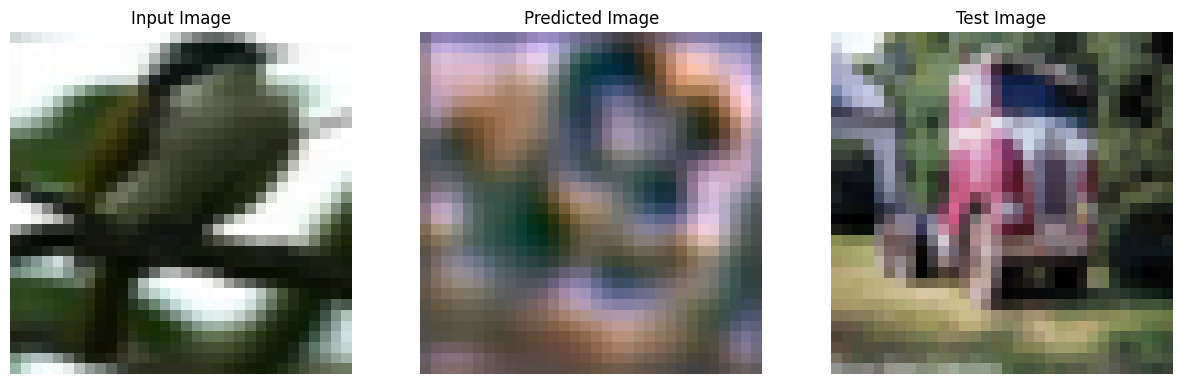

Epoch:425 GIAO Train Loss:0.5932128429412842


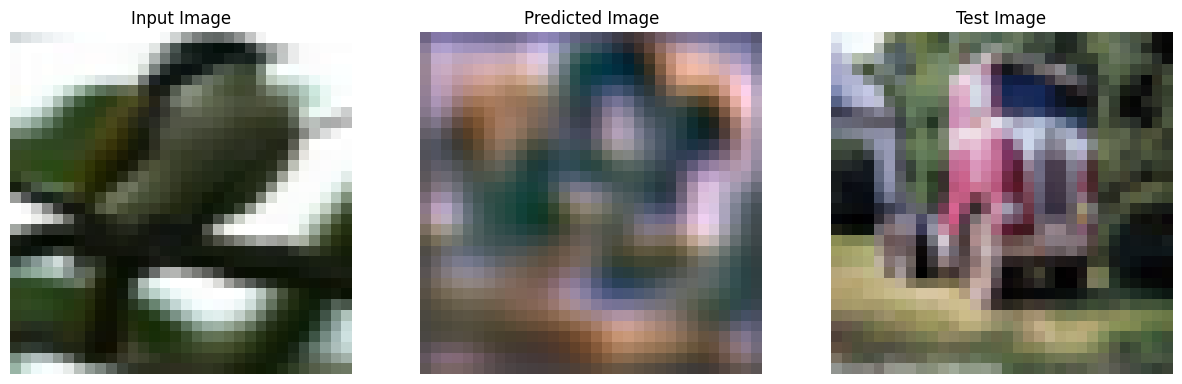

Epoch:450 GIAO Train Loss:0.43311601877212524


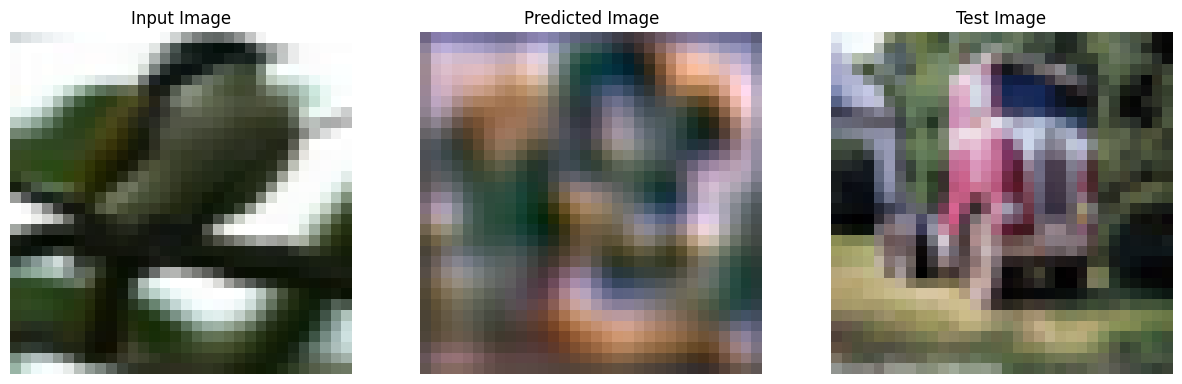

Epoch:475 GIAO Train Loss:0.2502633035182953


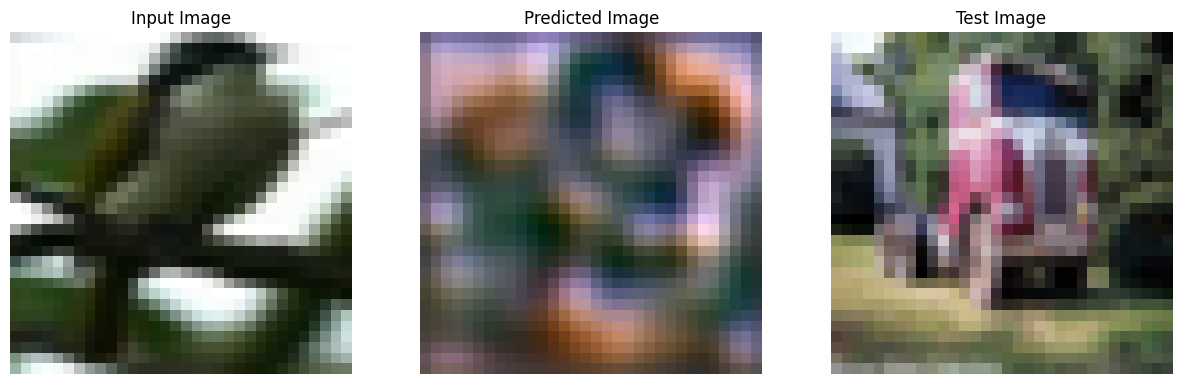

Epoch:500 GIAO Train Loss:0.603839635848999


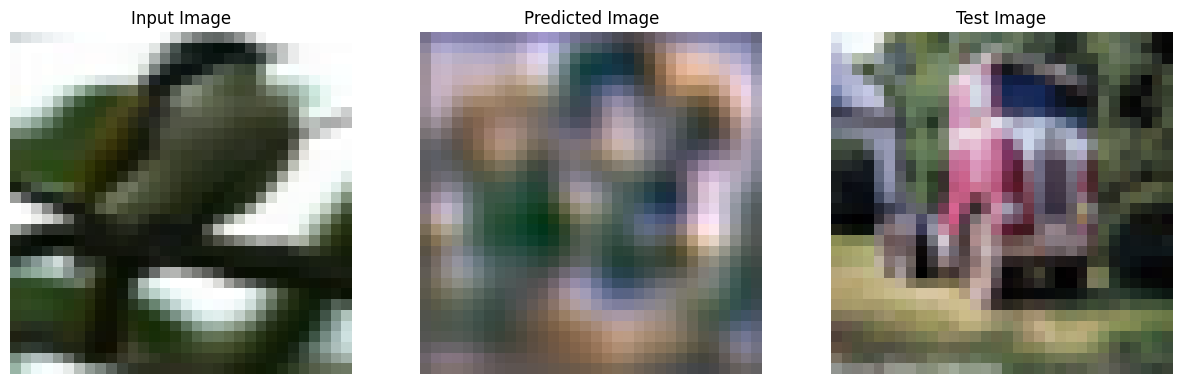

Epoch:525 GIAO Train Loss:0.3173266053199768


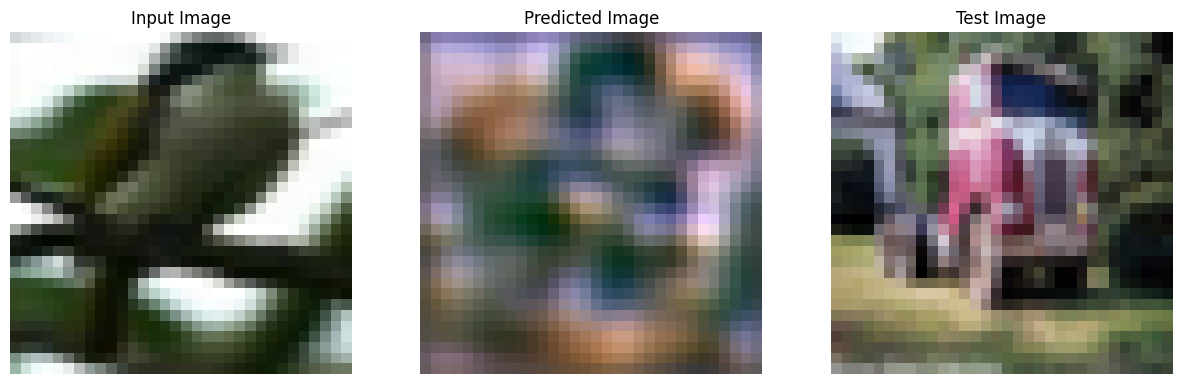

Epoch:550 GIAO Train Loss:0.8006618022918701


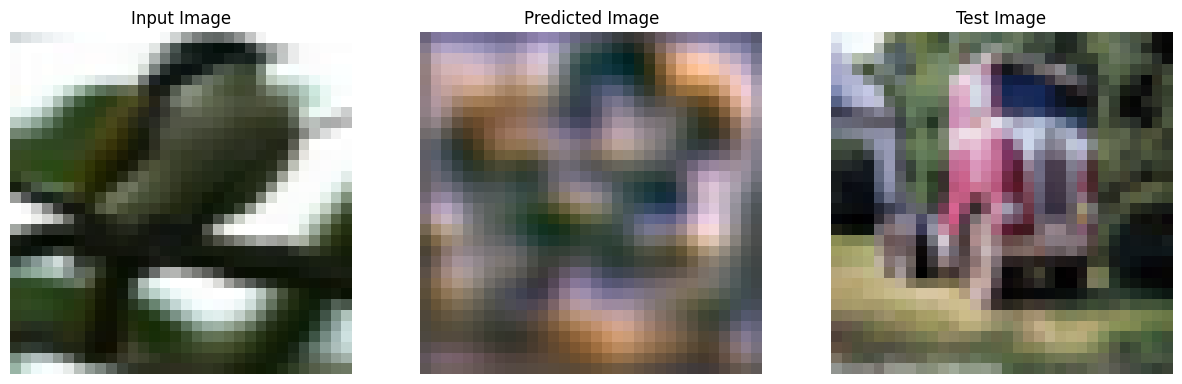

Epoch:575 GIAO Train Loss:0.35916686058044434


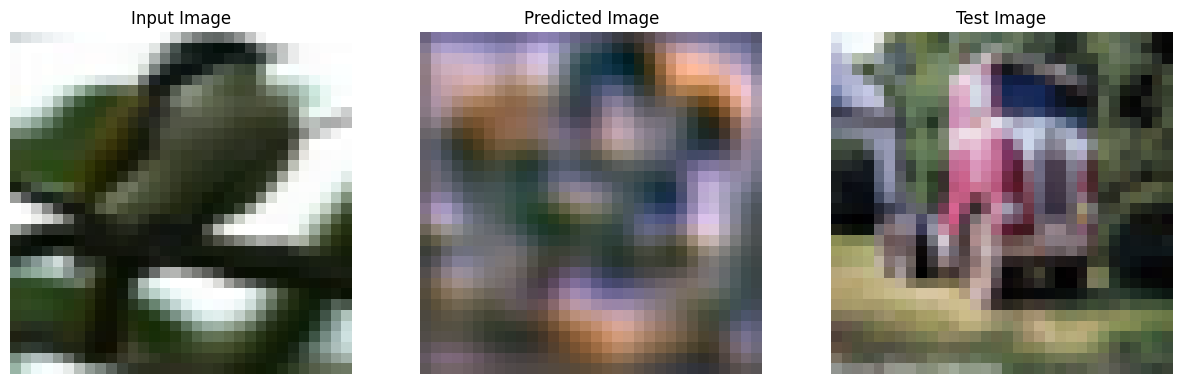

Epoch:600 GIAO Train Loss:0.3131171464920044


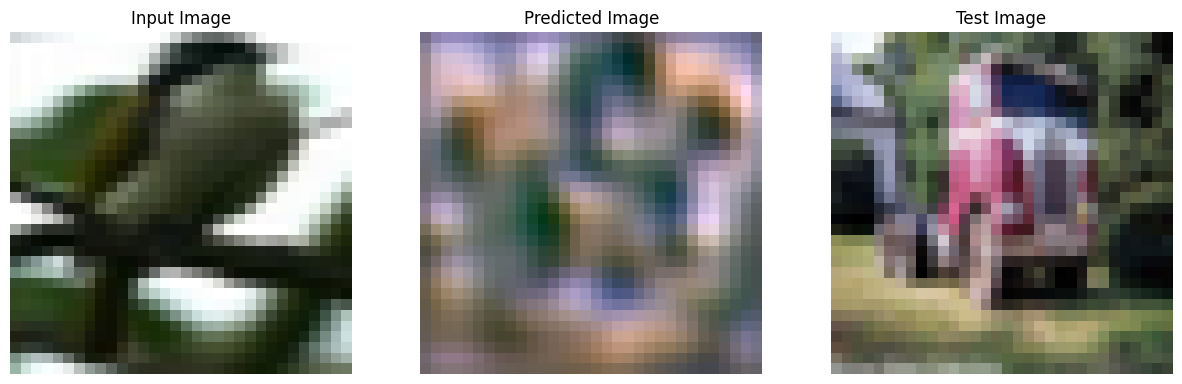

Epoch:625 GIAO Train Loss:0.31484103202819824


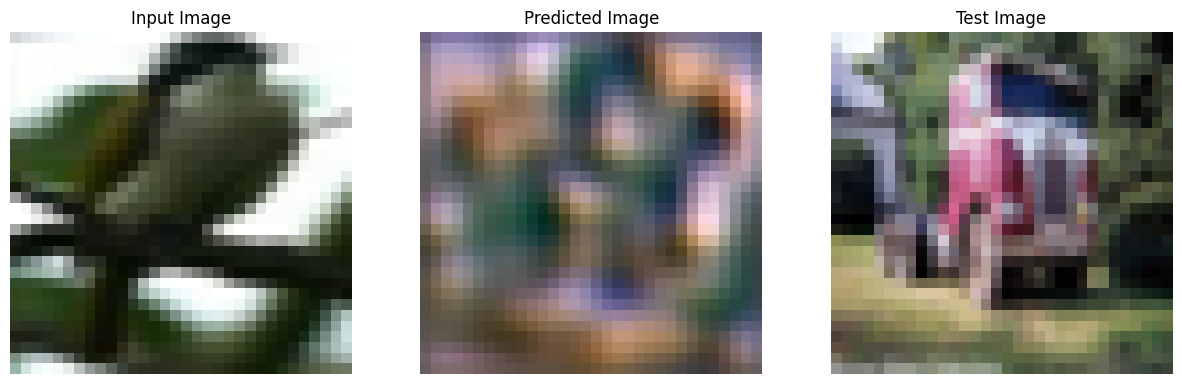

Epoch:650 GIAO Train Loss:0.3471020460128784


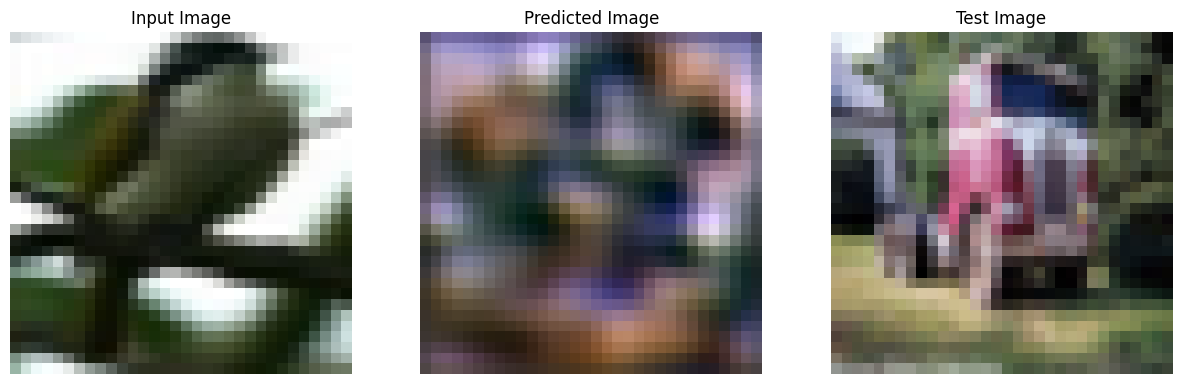

Epoch:675 GIAO Train Loss:0.3650861978530884


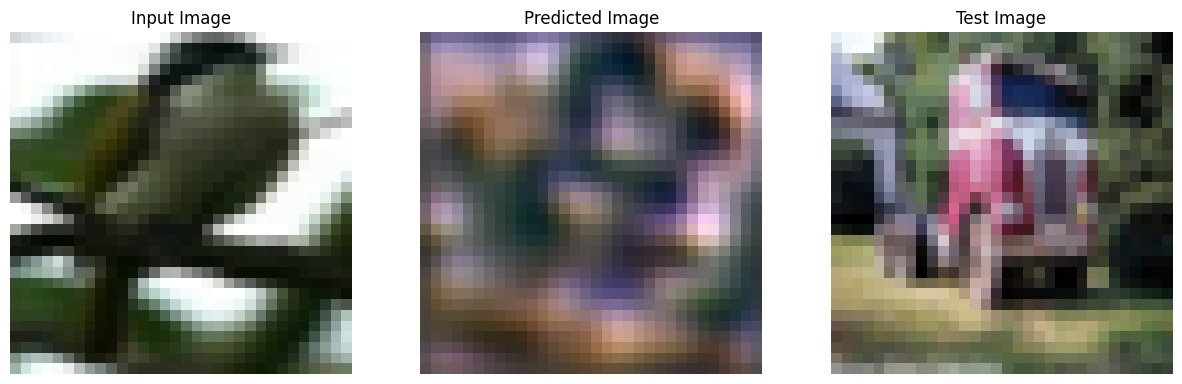

Epoch:700 GIAO Train Loss:0.353773832321167


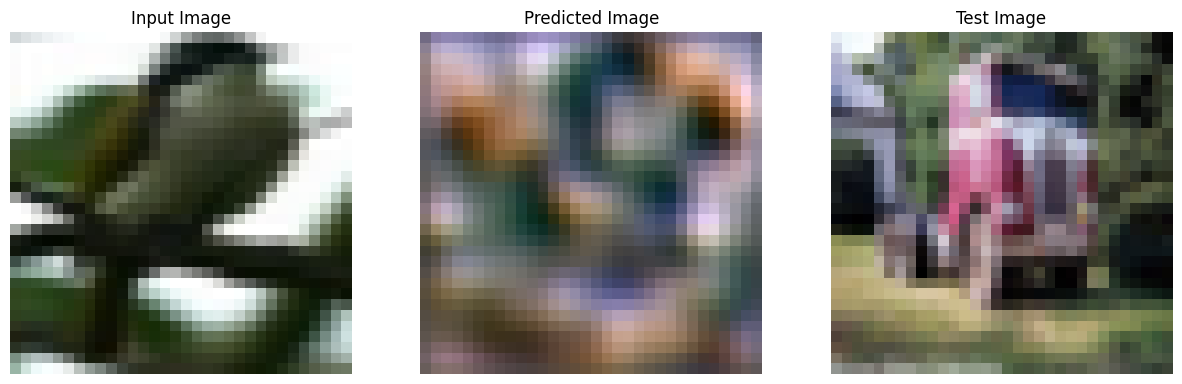

Epoch:725 GIAO Train Loss:0.2896883487701416


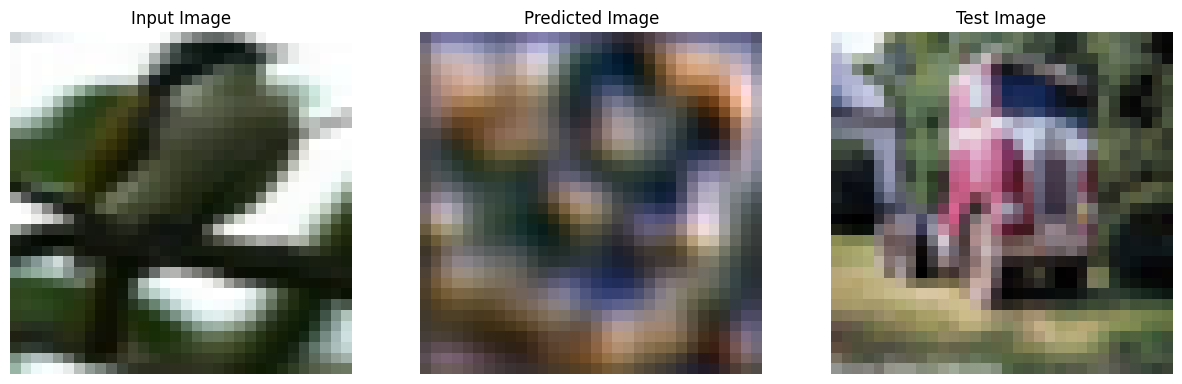

Epoch:750 GIAO Train Loss:0.3633262515068054


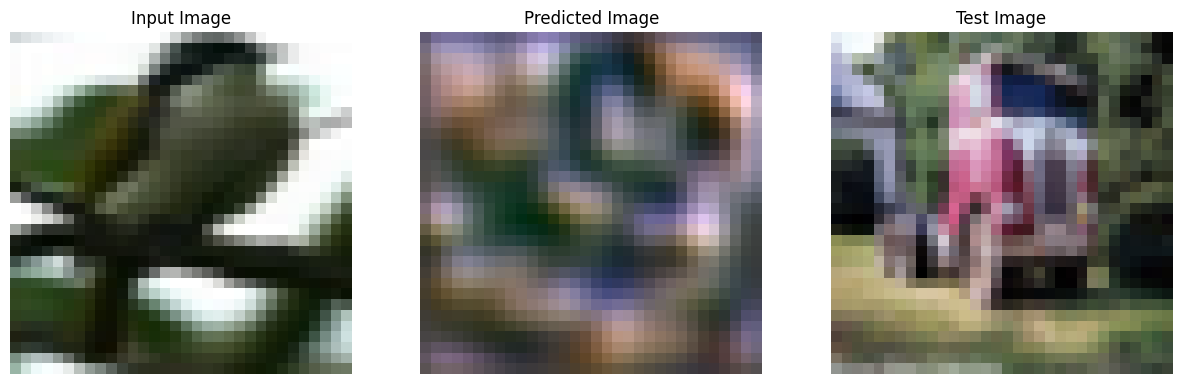

Epoch:775 GIAO Train Loss:0.41059553623199463


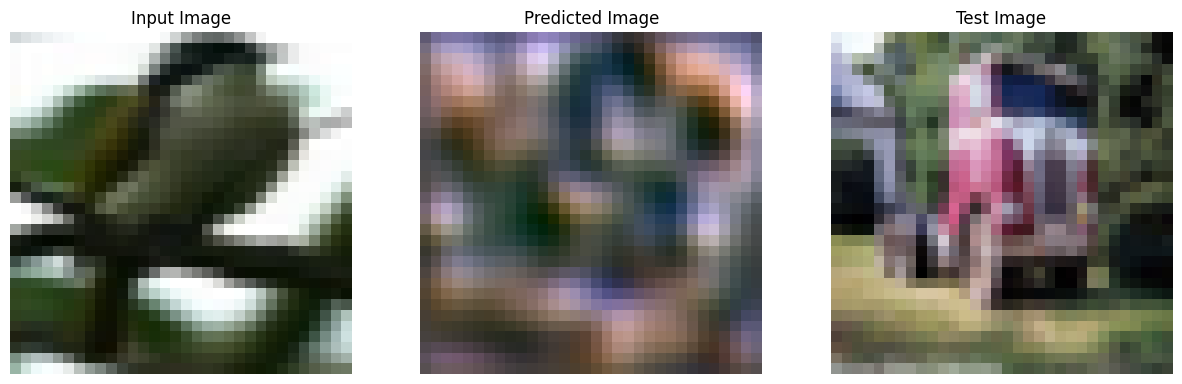

Epoch:800 GIAO Train Loss:0.44505101442337036


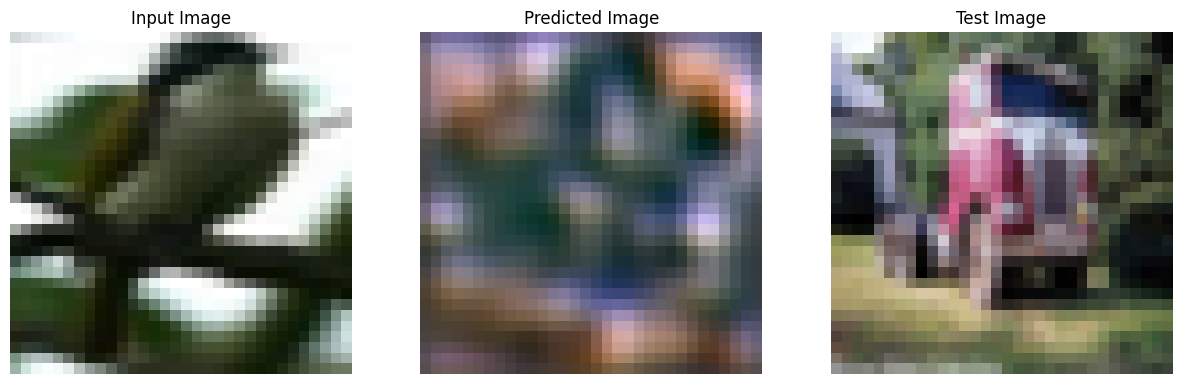

Epoch:825 GIAO Train Loss:0.3312762379646301


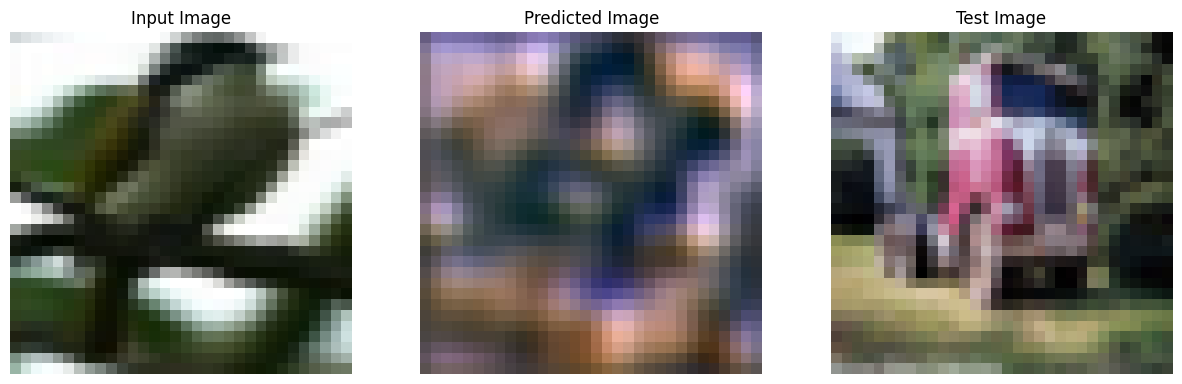

Epoch:850 GIAO Train Loss:0.4061572551727295


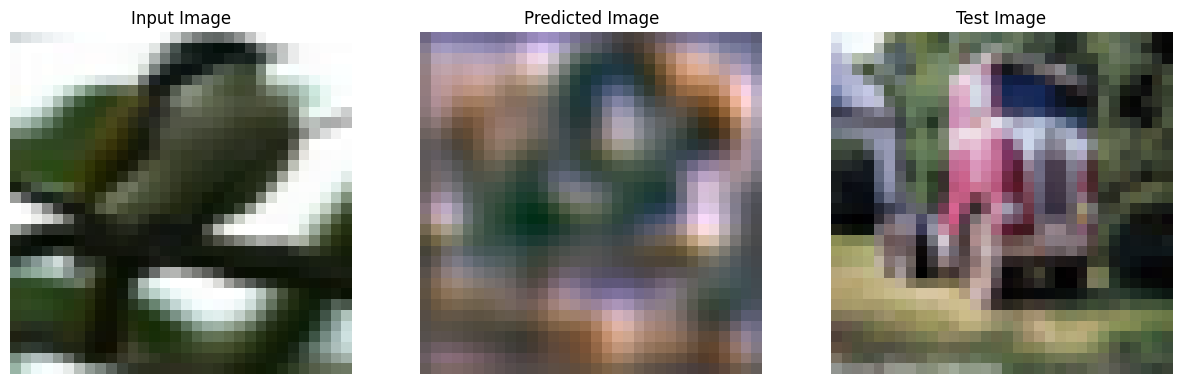

Epoch:875 GIAO Train Loss:0.2493932545185089


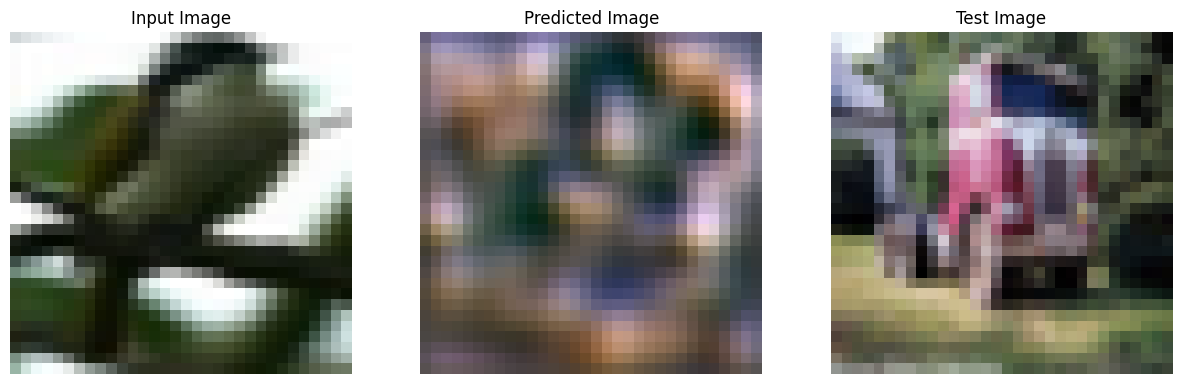

Epoch:900 GIAO Train Loss:0.46905016899108887


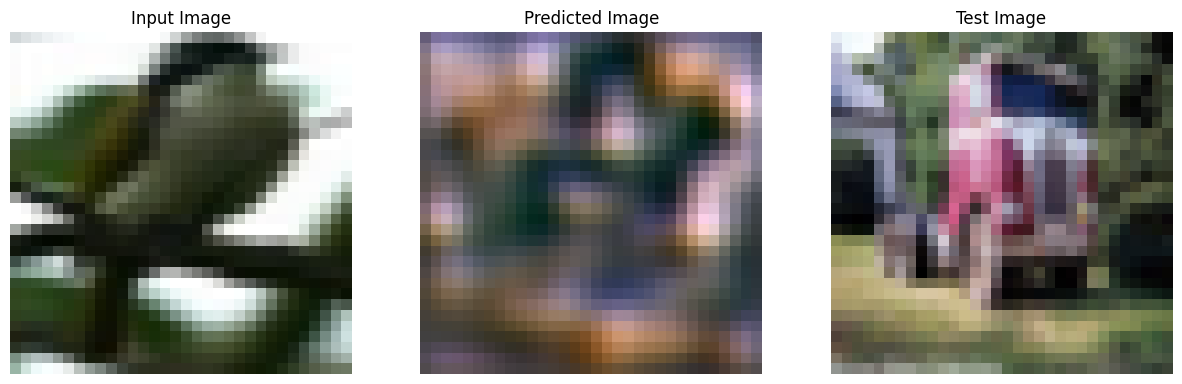

Epoch:925 GIAO Train Loss:0.36205968260765076


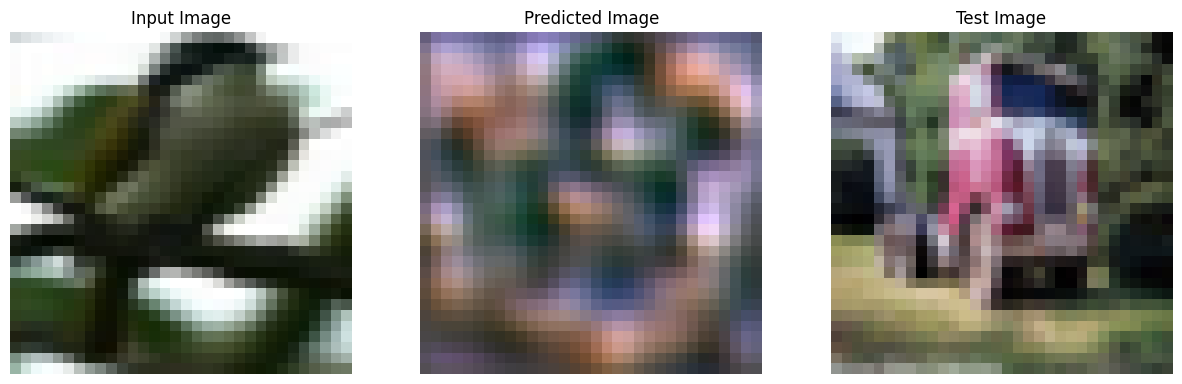

Epoch:950 GIAO Train Loss:0.31826451420783997


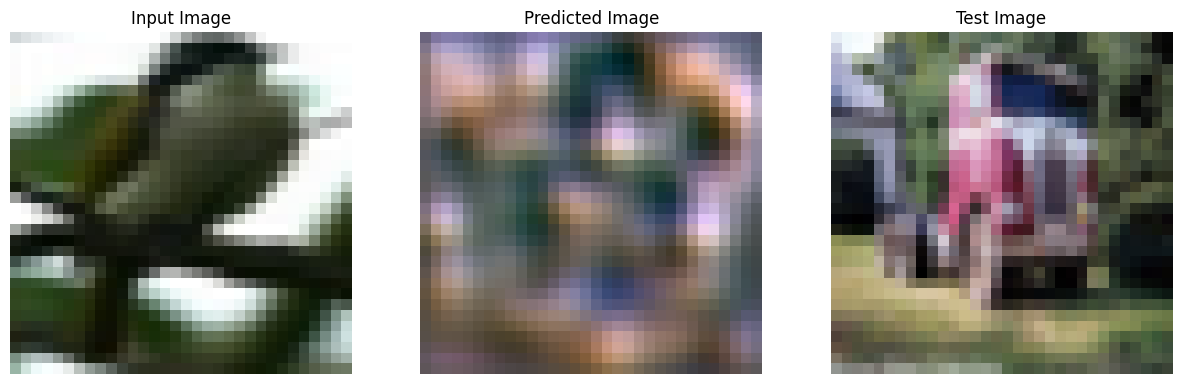

Epoch:975 GIAO Train Loss:0.4023272395133972


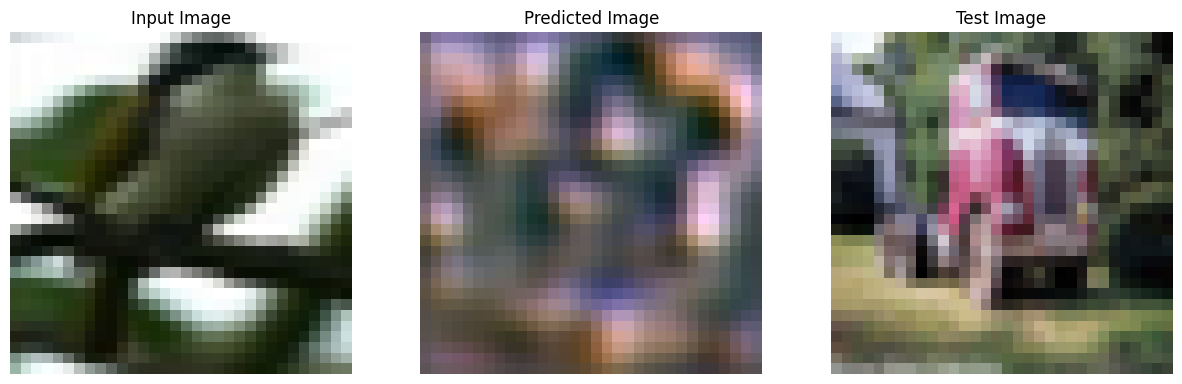

In [15]:
for i in range(GIAO_EPOCH):
    idx = random.sample(range(len(model_opt)), GIAO_BATCH)
    labels = [opt_label[i] for i in idx]
    regs = [model_opt[i] for i in idx]
    giao_train_loss, pseudo_inputs = _opt_train_step(unet, regs, train_data["inputs"], train_data["labels"], labels)
    if i % 25 == 0:
        print("Epoch:{} GIAO Train Loss:{}".format(i, giao_train_loss))
        display([train_data["inputs"].numpy()[0], pseudo_inputs.numpy()[0], test_data["inputs"][0]])

In [ ]:
# code test
for i in range(3):
    display([train_data["inputs"].numpy()[i], pseudo_inputs.numpy()[i], test_data["inputs"].numpy()[i]])

In [ ]:
# save model opt
hard_save_model_opt(model_opt)

In [ ]:
# load model opt
model_opt = load_model_opt()

In [ ]:
# metrics visualization
plot_train([records.train_loss, records.test_loss])
plot_train([opt_label, opt_label])

In [ ]:
train_data = iter_train.get_next()

unet = UNet(input_shape=[32, 32, 3])
output = unet(train_data["inputs"])
print(output.shape)
display([train_data["inputs"].numpy()[0],output.numpy()[0]])